## MSc Research Project

### Student ID: 202116447

## Science in Poetry

**Science poems:** poems that talk about a scientific phenomenon or concept. Can use regular language or scientific language.

Science poems scraped from: https://collectingreality.wordpress.com/, https://poets.org/poems and 14 issues of the Consilence Journal.

Non-science poems scraped from https://huggingface.co/datasets/merve/poetry/viewer/merve--poetry/train

Poems scraped using Pyhton's `requests` and `beautifulsoup4` libraires; then saved in csv files (As seen in Scraper.ipynb)


In [14]:
# !pip install preprocessor
# !pip install wordcloud
# !pip install gensim
# !pip install keras
# !pip install tensorflow
# !pip install joblib

#### import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import preprocessor as p
import re

import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk import ngrams

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, precision_score

import joblib
import pickle

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\molab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# DATA COLLATION

## Scientific Poems

__Read and merge the scientific csv files:__

From the scraping exercise, the science poems were stored in 8 files depending on the site they was scraped from.

Science poems are scraped to have three columns: `Title`, `Content` and `Science`

Science is 1 for science poems and 0 for non-science poems

In [60]:
# reading the csv files

df1 = pd.read_csv('sci-poems1.csv')

In [61]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    189 non-null    object
 1   Content  189 non-null    object
 2   Science  189 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ KB


In [62]:
df2 = pd.read_csv('sci-poems2.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    95 non-null     object
 1   Content  94 non-null     object
 2   Science  95 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


__A quick `for loop` to concatenate all the science poems dataframes__

In [8]:
df = pd.DataFrame()

for i in range(3,8):
    fn = f'sci-poems{i}.csv'
    dfn = f'df{i}'
    dfn = pd.read_csv(fn)
    df = pd.concat([df, dfn], ignore_index=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    270 non-null    object
 1   Content  265 non-null    object
 2   Science  270 non-null    object
dtypes: object(3)
memory usage: 6.5+ KB


### Concatenate the dataframes

In [12]:
df = pd.concat([df, df1], ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    554 non-null    object
 1   Content  548 non-null    object
 2   Science  554 non-null    object
dtypes: object(3)
memory usage: 13.1+ KB


### Save the 'science' dataframe as CSV

Save all the science poems into a csv file

In [14]:
df.to_csv('sci-poems0.csv', index=False)

In [63]:
odf = pd.read_csv('sci-poems0.csv')
odf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    539 non-null    object
 1   Content  533 non-null    object
 2   Science  539 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.8+ KB


## Non-science Poems


__Read scrapped non-science poems__

In [64]:
df = pd.read_csv('Poetry.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     573 non-null    object
 1   content    573 non-null    object
 2   poem name  571 non-null    object
 3   age        573 non-null    object
 4   type       573 non-null    object
dtypes: object(5)
memory usage: 22.5+ KB


In [65]:
df.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [66]:
df['type'].unique()

array(['Mythology & Folklore', 'Nature', 'Love'], dtype=object)

In [67]:
df['age'].unique()

array(['Renaissance', 'Modern'], dtype=object)

### Get only modern poems

In [68]:
dfa = df.loc[df['age'] == 'Modern']
dfa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 315 to 572
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     258 non-null    object
 1   content    258 non-null    object
 2   poem name  256 non-null    object
 3   age        258 non-null    object
 4   type       258 non-null    object
dtypes: object(5)
memory usage: 12.1+ KB


__Remove unwanted columns__

In [69]:
dfa.drop(columns=['author', 'poem name', 'age', 'type'], axis=1, inplace=True)

dfa.head()

C:\Users\molab\AppData\Local\Temp\ipykernel_15092\2430221238.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa.drop(columns=['author', 'poem name', 'age', 'type'], axis=1, inplace=True)


,content
315,"I leaned against the mantel, sick, sick,\r\nTh..."
316,I was the first fruits of the battle of Missio...
317,I was only eight years old;\r\nAnd before I gr...
318,"W. B. Yeats, Lapis Lazuli from The Poems of W...."
319,Why should I blame her that she filled my days...


__Add the `Science` column with the value `0` to the non-science poems dataset__

In [70]:
# add categorical column as unscientific

dfa['Science'] = 0

C:\Users\molab\AppData\Local\Temp\ipykernel_15092\2263986652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa['Science'] = 0


In [71]:
dfa

,content,Science
315,"I leaned against the mantel, sick, sick,\r\nTh...",0
316,I was the first fruits of the battle of Missio...,0
317,I was only eight years old;\r\nAnd before I gr...,0
318,"W. B. Yeats, Lapis Lazuli from The Poems of W....",0
319,Why should I blame her that she filled my days...,0
...,...,...
568,"With the man I love who loves me not,\r\nI wal...",0
569,"Hart Crane, ""Voyages I, II, III, IV, V, VI"" fr...",0
570,"When you are old and grey and full of sleep,\r...",0
571,"Give me hunger,\r\nO you gods that sit and giv...",0


### Save the new non-science poems to csv file

In [72]:
dfa.to_csv('nsci-poems.csv', index=False)

In [73]:
odf.head()

,Title,Content,Science
0,A Body Under Control,"Content warning: eating disorders, body dysmor...",1
1,A Quantum of Truth,I first met Niels Bohr on the metaphysical for...,1
2,An Ode on a Blobfish,Thou ravish’d bride of deep-sea trawlers— ...,1
3,can the sea drown?,"all overi went looking for myself: shelf, slop...",1
4,Chiarezza,"Words, speech, deepen, Breaking through the me...",1


__Merge both datasets into one__

First, drop the `Title` column in the science poems csv file

In [74]:
odf.drop('Title', axis=1, inplace=True)
odf.head()

,Content,Science
0,"Content warning: eating disorders, body dysmor...",1
1,I first met Niels Bohr on the metaphysical for...,1
2,Thou ravish’d bride of deep-sea trawlers— ...,1
3,"all overi went looking for myself: shelf, slop...",1
4,"Words, speech, deepen, Breaking through the me...",1


__Rename the columns in the non-science dataframe and merge both dataframes__

In [75]:
dfa.columns = ['Content', 'Science']

df = pd.concat([dfa, odf], ignore_index=True)

df.sample(10)

,Content,Science
301,"Gravity is a silent bully.With enough mass, he...",1
579,The moon is the mother of pathos and pity.When...,1
317,"After years of astute study,a profound hypothe...",1
664,"Poems need not be about science, but can use s...",1
174,The ancient songs\r\nPass deathward mournfully...,0
40,Knock knock He has closed his door\r\nThe gard...,0
7,She was a village\r\nOf lovely knowledge\r\nTh...,0
536,"Probably you’ll solve gravity, flesh out our ...",1
159,"Now in the West the slender moon lies low,\r\n...",0
115,"Even iron can put forth,\r\nEven iron.\r\n\r\n...",0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  791 non-null    object
 1   Science  797 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


__Save all the poems to one csv file__

In [77]:
# save as csv

df.to_csv('all-poems.csv', index=False)

# DATA CLEANING

### Cleaning Steps:
- Check for null values: remove any if found
- Check for duplicate rows
- Check for whitespaces
- Remove irrelevant words
- Remove hashtags, usernames and special characters

In [19]:
df = pd.read_csv('all-poems.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  644 non-null    object
 1   Science  650 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.3+ KB


__Check for null values__

In [5]:
# check for null values

df.isnull().sum()

Content    6
Science    0
dtype: int64

__View the null rows__

In [6]:
# view null rows
df_null = df[df.isna().any(axis=1)]
df_null

,Content,Science
198,NaN,1
199,NaN,1
256,NaN,1
294,NaN,1
353,NaN,1
475,NaN,1


__Get rid of the null values and chekc again__

In [20]:
# drop null rows and check again
df.dropna(inplace=True)
df.isnull().sum()

Content    0
Science    0
dtype: int64

__Check for duplicates__

In [21]:
# check for duplicates
df.duplicated().sum()

39

__Get rid of duplicated rows__

In [9]:
# view duplicates
df[df.duplicated()]

,Content,Science
34,Only the wanderer\r\n Knows England's graces...,0
35,"He's gone, and all our plans\r\n Are useless...",0
51,My bands of silk and miniver\r\nMomently grew ...,0
59,"There may be chaos still around the world,\r\n...",0
76,in Just-\r\nspring when the world is ...,0
79,We passed old farmer Boothby in the field.\r\n...,0
101,"Momus is the name men give your face,\r\nThe b...",0
104,"Potuia, potuia\r\nWhite grave goddess,\r\nPity...",0
105,The ancient songs\r\nPass deathward mournfully...,0
110,Why should I blame her that she filled my days...,0


In [10]:
# check unique poems
df['Content'].nunique()

605

In [22]:
# drop duplicates
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.duplicated().sum()

0

__Check for extra white spaces, links, breaks, new line tags and hashtags__

In [12]:
# check for extra white spaces
print('===Contains white spaces===')
print(df['Content'].str.match('\s\s+').value_counts())

# check for URLS
print('===Contains URLS===')
print(df['Content'].str.contains('http').value_counts())

# check for Breaks
print('===Contains Line Starts===')
print(df['Content'].str.contains('\r').value_counts())

# check for New Lines
print('===Contains New Line===')
print(df['Content'].str.contains('\n').value_counts())

# check for hashtags
print('===Contains hashtags===')
print(df['Content'].str.match('#(\w+)').value_counts())

===Contains white spaces===
False    563
True      42
Name: Content, dtype: int64
===Contains URLS===
False    605
Name: Content, dtype: int64
===Contains Line Starts===
False    304
True     301
Name: Content, dtype: int64
===Contains New Line===
False    304
True     301
Name: Content, dtype: int64
===Contains hashtags===
False    605
Name: Content, dtype: int64


__Clean:__ 

__Remove trailing spaces, remove double spaces, remove symbols and spcial characters, take to lower case, links etc using preprocesor__

__To avoid code repetition, write a function for these steps__

In [30]:
def clean_poem(poem):
    """
    remove symbols, spaces and change the given text to lower letter
    """
    # strip trailing spaces
    poem = poem.strip()
    # change to lowercase
    poem = poem.lower()
    # remove new lines & line starts
    poem = re.sub(r'\b\n', ' ', poem)
    poem = re.sub(r'\b', '', poem)
    poem = re.sub(r'\n', '', poem)
    # remove digits
    poem = re.sub('\d+', ' ', poem)
    # remove punctuations
    poem = re.sub("[,-\.`_!?]", ' ', poem)
    poem = re.sub("[']", '', poem)
    return poem

def preprocess_poem(poem):
    """
    remove links, emojis, smileys, hashtags from a given text
    """
    return p.clean(poem)

__Lematize and tokenize.__

__But before lematising and tokenizing, save a copy of the data set without removing key words for future experimentation__

In [23]:
# make a copy of df

df_un = df
df_un.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  605 non-null    object
 1   Science  605 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


In [47]:
lemmatizer = nltk.stem.WordNetLemmatizer()
# word_tokenizer_ = Tokenizer()

def lemmatize_text(text):
    """Returns the stem word of each tokenized woek in a given text"""
    return [(lemmatizer.lemmatize(w)) for w in word_tokenize(text)]

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    """Returns only words that are not English stop words"""
    w = [item for item in lemmatize_text(text) if item not in stop_words]
    return ' '.join(w)

def remove_quotes(text):
    """Remove punctuations and quotes from the text"""
    return re.sub('["<>:;()`*]', '', text)

__Perform the actual cleaning by calling the functions on the dataset. Save cleaned poems to another column__

In [25]:
# preprocess the poems and save to another column

# preprocess poem
df['cleaned'] = df['Content'].apply(str).map(lambda x: preprocess_poem(x))

# clean poem
df['cleaned'] = df['cleaned'].apply(str).map(lambda x: clean_poem(x))

# lemmatize and remove stop words 
df['cleaned'] = df['cleaned'].apply(str).map(lambda x: remove_stopwords(x))

# final clean
df['cleaned'] = df['cleaned'].apply(str).map(lambda x: remove_quotes(x))

In [26]:
df.sample(15)

,Content,Science,cleaned
520,"I am like a slip of comet,\r\nScarce worth dis...",1,like slip comet scarce worth discovery corner ...
417,Nothing is more important to the ant whose exo...,1,nothing important ant whose exoskeleton ha bre...
212,I arranged near hungry riverin gasps consume. ...,1,arranged near hungry riverin gasp consume win ...
537,"\r\n“The Geometry of Gravity,”\r\nreads the c...",1,geometry gravity read card museum displaywhere...
397,"Probably you’ll solve gravity, flesh out our ...",1,probably youll solve gravity flesh microbiomic...
588,Far star that tickles for me my sensitive plat...,1,far star tickle sensitive plateand fry couple ...
316,"Working in the lab on a hot summer morning,wei...",1,working lab hot summer morning weighing sample...
419,"How, Alan Turing thought, does the soft-walled...",1,alan turing thought doe soft walled jellied sy...
448,"Perhaps I shine brightest now,\r\nbut my energ...",1,perhaps shine brightest energy ha changed kno...
149,The craters within me shift. There is a gap. W...,1,crater within shift gap lean like season cycle...


### Save cleaned dataset to csv

In [27]:
df.drop('Content', axis=1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Science  605 non-null    int64 
 1   cleaned  605 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


In [29]:
df.to_csv('cleaned-poems.csv', index=False)

In [2]:
df = pd.read_csv('cleaned-poems.csv')

# VISUALISATIONS

### Compare the frequency of Scientific Poems to Non-scientific Poems

Total Number of Scientific Poems:  468
Total Number of Non-Scientific Poems:  137


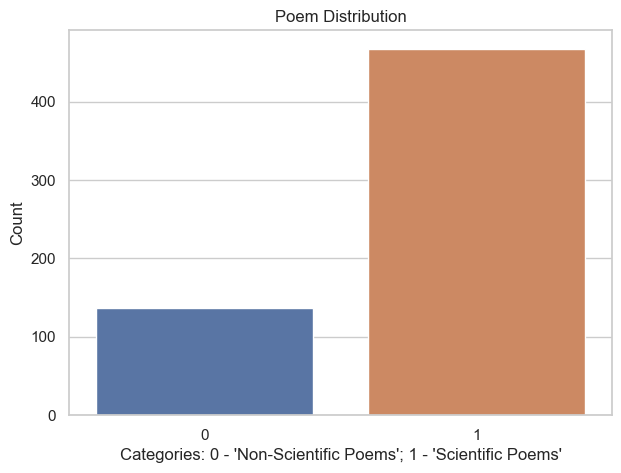

In [4]:
print('Total Number of Scientific Poems: ', len(df.loc[df['Science'] == 1])) 
print('Total Number of Non-Scientific Poems: ', len(df.loc[df['Science'] == 0]))

# plot the counts 
sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(7,5))
distribution = sns.countplot(x="Science", data=df)
distribution.set_ylabel("Count")
distribution.set_xlabel("Categories: 0 - 'Non-Scientific Poems'; 1 - 'Scientific Poems'")
plt.title("Poem Distribution")
plt.savefig('./images/poem-distribution')
plt.show()

### Investigate the most common n-grams in both categories of poems

In [32]:
# write a function to reduce code repetition
def frequency_words(text, top, labelss):
    """
    This function finds the top words in a given text
    
    Inputs:
    text (str): the text to be analysed; in this case, the poem
    top (int): the top n-gram(s) to be gotten. e.g to ten 1/2/3-grams
    labelss (str): the label of the data category
    
    Output:
    Returns a dataframe containing the top words and their counts
    """
    lst_tokens = nltk.tokenize.word_tokenize(text.str.cat(sep=" "))
    ngrams = [1,2,3]
    
    temp_df = pd.DataFrame()
    
    # for 1,2,3 words get the most freq and their counts, save to the temp df
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        temp_df = pd.concat([temp_df, dtf_n], ignore_index=True) 
    
    # append df in loop to original temporary df
    temp_df["word"] = temp_df["word"].apply(lambda x: " ".join(string for string in x) )
    temp_df = temp_df.sort_values(["ngrams","freq"], ascending=[True,False])
    
    # plot the words
    fig, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel= "Words Frequency")
    ax.set(ylabel= "Common Words")
    plt.title(f"Top {top} Words per n-grams for {labelss} Poems")
    plt.savefig(f"./images/top-{top}-words-for-{labelss}-poems")
    plt.show()
    ax.grid(axis="x")
    return temp_df

Category: Non Scientific Poem


C:\Users\molab\AppData\Local\Temp\ipykernel_6760\428522213.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))


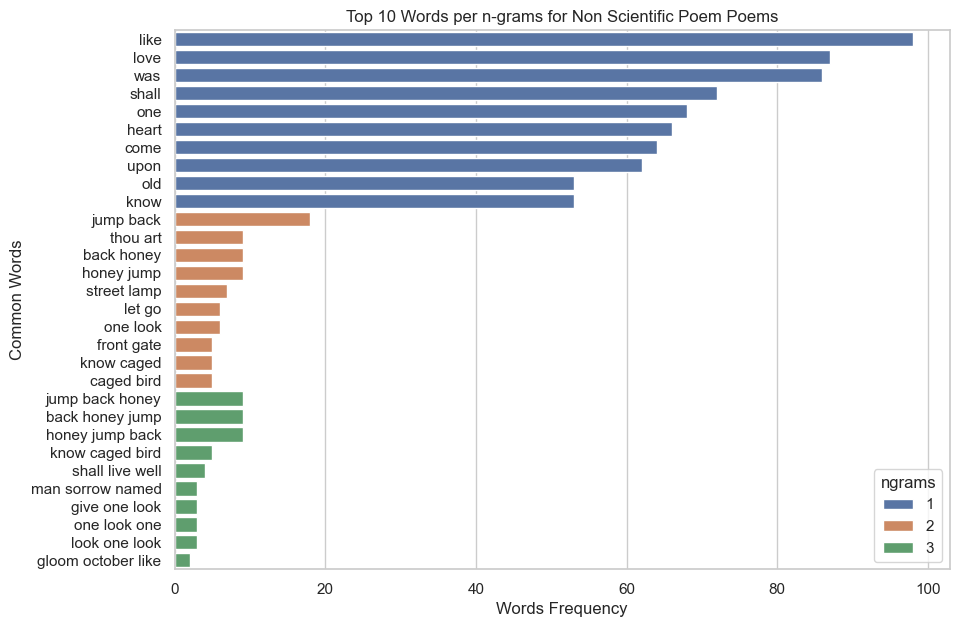

Category: Scientific Poem


C:\Users\molab\AppData\Local\Temp\ipykernel_6760\428522213.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))


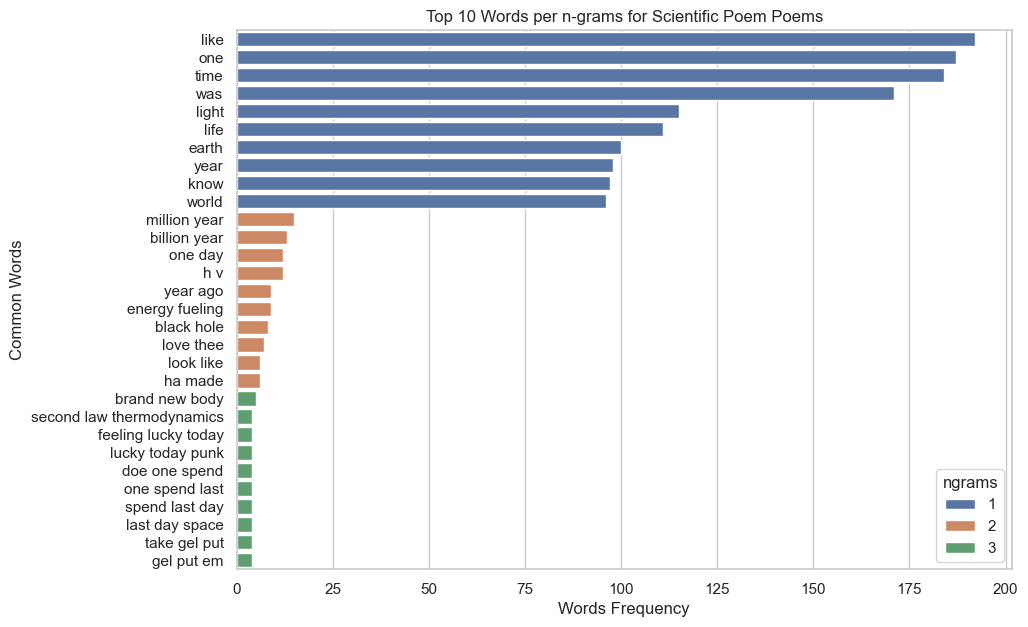

In [55]:
# cretae a temporary dataframe to store the results
temp_df = pd.DataFrame()
for label in df['Science'].unique():
    if label == 1:
        text = 'Scientific Poem'
    else:
        text = 'Non Scientific Poem'
    print(f'Category: {text}')
    df_temp = frequency_words(dff[dff['Science'] == label]['cleaned'], 10, text)
    df_temp['Science'] = label
    temp_df = pd.concat([temp_df, df_temp], ignore_index=True)

__For experimental purposes: investigate the frequencies of the most common n-grams__

In [94]:
temp_df.loc[(temp_df['Science'] == 1) & (temp_df['freq'] >= 6)]

,word,freq,ngrams,Science
34197,like,192,1,1
34198,one,187,1,1
34199,time,184,1,1
34200,was,171,1,1
34201,light,115,1,1
...,...,...,...,...
47406,solar system,6,2,1
47407,second law,6,2,1
47408,leaf arent,6,2,1
47409,probably probably,6,2,1


### Re-assessment

__Let's reaccess this ngrams without the removal of stop words__

__Clean the copied dataframe without removing ths stopwords and investigate the top n-grams. This is to discover if the ngrams will change without the stop words.__

In [41]:
df_un = pd.read_csv('all-poems.csv')

# drop null values
df_un.dropna(inplace=True)
print(f'Null values - {df_un.isnull().sum()}')

# drop duplicates
df_un.dropna(inplace=True)
print(f'Duplicates - {df_un.isnull().sum()}')

# preprocess poem
df_un['cleaned'] = df_un['Content'].apply(str).map(lambda x: preprocess_poem(x))

# clean poem
df_un['cleaned'] = df_un['cleaned'].apply(str).map(lambda x: clean_poem(x))

df_un['cleaned'] = df_un['cleaned'].apply(str).map(lambda x: remove_quotes(x))

df_un.sample(10)

Null values - Content    0
Science    0
dtype: int64
Duplicates - Content    0
Science    0
dtype: int64


,Content,Science,cleaned
28,I have built a house in the middle of the Ocea...,0,i have built a house in the middle of the ocea...
349,Earth refuses to draw clean circles. In a seve...,1,earth refuses to draw clean circles in a seve...
50,"Man, looking into the sea\r\ntaking the view f...",0,man looking into the seataking the view from ...
277,Do black and white swans fight to the deathDoe...,1,do black and white swans fight to the deathdoe...
635,Another Biology poem for the collection:\r\nPo...,1,another biology poem for the collectionetry s...
30,Although you hide in the ebb and flow\r\nOf th...,0,although you hide in the ebb and flowof the pa...
338,When a tree keels over in a clearingdeeper in ...,1,when a tree keels over in a clearingdeeper in ...
303,from obscurity to incandescence ...,1,from obscurity to incandescence in an elongate...
304,"Our fiery ringmaster Sol, rumbles and purrs. H...",1,our fiery ringmaster sol rumbles and purrs he...
186,Strands of fern firmly push up through the ash...,1,strands of fern firmly push up through the ash...


Category: Scientific Poem But With Stop Words


C:\Users\molab\AppData\Local\Temp\ipykernel_6760\428522213.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax, data=temp_df.groupby('ngrams')["ngrams","freq","word"].head(top))


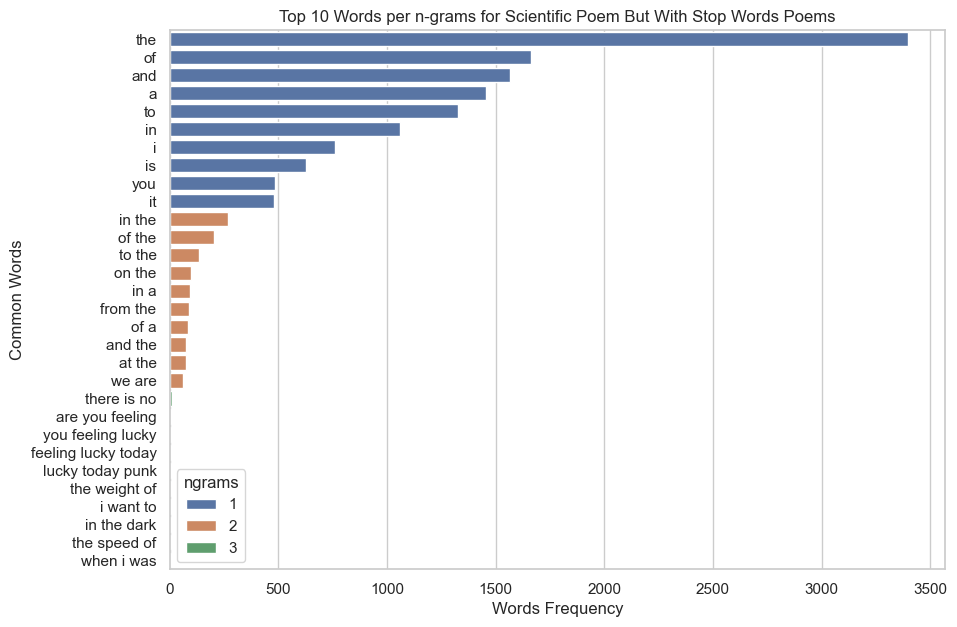

In [42]:
temp_df = pd.DataFrame()
for label in df_un['Science'].unique():
    if label == 1:
        text = 'Scientific Poem But With Stop Words'
        print(f'Category: {text}')
        df_temp = frequency_words(df_un[df_un['Science'] == label]['cleaned'], 10, text)
        df_temp['Science'] = label
        temp_df = pd.concat([temp_df, df_temp], ignore_index=True)

__The top ngrams are mainly prepositions and adjectives. We will ignore this dataset henceforth__


### WordClouds

__Write a function to reduce code repitition__

In [48]:
def plot_wordcloud(text, labelsss, max_words=100, max_font_size=45):
    """
    a function to plot the wordcloud
    input:
    text (str) - text,
    labelsss (str) - the category
    max_word (int) - default 100. the max number of words in the wordclid
    max_font_size (int) - default 45;
    
    """
    wordcloud = WordCloud(max_font_size=max_font_size, max_words=max_words)
    wordcloud = wordcloud.generate(str(text))
    fig = plt.figure(figsize=(10,7))
    plt.title(f"Word Cloud for {labelsss} Poems")
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig(f"./images/{labelsss}-poems")
    plt.show()

Category: Non Science


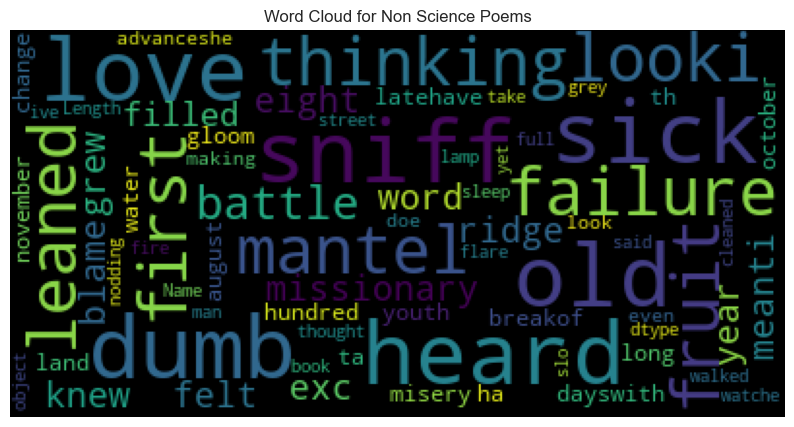

Category: Science


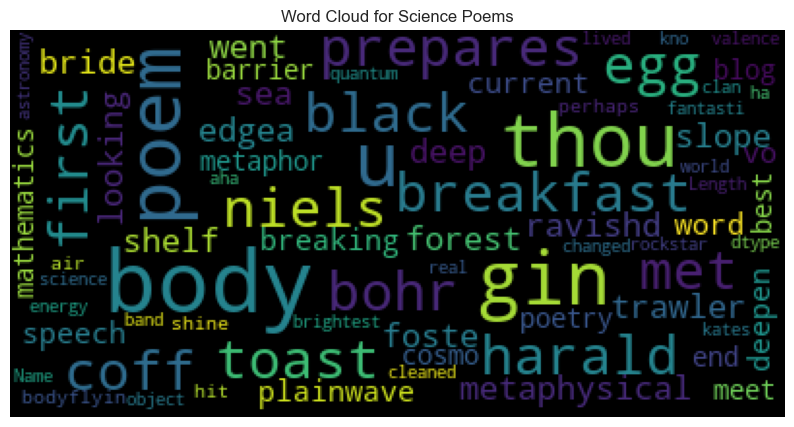

In [56]:
# plot for both categoroes
for label in dff['Science'].unique():
    if label == 1:
        text = 'Science'
    else:
        text = 'Non Science'
    print('Category: {}'.format(text))
    plot_wordcloud(dff[dff['Science'] == label]['cleaned'], text)

# DBSCAN CLUSTERING


### Vectorisation using TD-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

In [61]:
# convert poems to list
science_poems_as_list = dff[dff['Science'] == 1]['cleaned'].to_list()

In [63]:
non_science_poems_as_list = dff[dff['Science'] == 0]['cleaned'].to_list()

In [64]:
all_poems_as_list = dff['cleaned'].to_list()

In [65]:
# vectorize the poems
vectorizer = TfidfVectorizer()
science_vectors = vectorizer.fit_transform(science_poems_as_list)
non_science_vectors = vectorizer.fit_transform(non_science_poems_as_list)
all_vectors = vectorizer.fit_transform(all_poems_as_list)

__Calculate the `similarity matrix` of each poem in the list__

__This is the square matrix where each vecorized text in the list is represented by the cosine similarity of two words - a symmetric matric with diagonals of 1. This similarity matrix is used as input into the DBSCAN instead of the actual text for better results.__

In [66]:
# calculate the similarity matrix of each

sci_simi_matrix = cosine_similarity(science_vectors)
non_sci_simi_matrix = cosine_similarity(non_science_vectors)
all_simi_matrix = cosine_similarity(all_vectors)

In [71]:
sci_simi_matrix

array([[1.        , 0.00433162, 0.01268466, ..., 0.0214296 , 0.00888653,
        0.04477822],
       [0.00433162, 1.        , 0.        , ..., 0.01182949, 0.02462119,
        0.00688977],
       [0.01268466, 0.        , 1.        , ..., 0.0073761 , 0.00253597,
        0.01032134],
       ...,
       [0.0214296 , 0.01182949, 0.0073761 , ..., 1.        , 0.00844499,
        0.00810426],
       [0.00888653, 0.02462119, 0.00253597, ..., 0.00844499, 1.        ,
        0.01450931],
       [0.04477822, 0.00688977, 0.01032134, ..., 0.00810426, 0.01450931,
        1.        ]])

In [72]:
# set dbscan parameters
eps = 1
min_samples = 2 

In [73]:
# Apply DBSCAN Algorithm to each with distance 1 and min_sample 2
dbscan = DBSCAN(eps=1, min_samples=2, metric='precomputed')
labels_sci = dbscan.fit_predict(sci_simi_matrix)
labels_non_sci = dbscan.fit_predict(non_sci_simi_matrix)
labels_all = dbscan.fit_predict(all_simi_matrix)

### Find Possible Science Poems Clusters

In [79]:
# Now analyse the clustering results
#science poems only
unique_sci_labels = set(labels_sci)
no_sci_clusters = len(np.unique(unique_sci_labels))
no_sci_noise = np.sum(np.array(unique_sci_labels) == -1, axis=0)

print(f'Number of clusters: {no_sci_clusters}')
print(f'Number of noise points: {no_sci_noise}')

# colors = list(map(lambda x: 'red' if x == 1 else 'blue', unique_sci_labels))
# plt.scatter(x, y, c=colors, marker="o", picker=True)
# plt.show()

Number of clusters: 1
Number of noise points: 0


__Only one cluster is found__

### Find Possible Non Science Poems Clusters

In [81]:
unique_non_sci_labels = set(labels_non_sci)
no_non_sci_clusters = len(np.unique(unique_non_sci_labels))
no_non_sci_noise = np.sum(np.array(unique_non_sci_labels) == -1, axis=0)

print(f'Number of clusters: {no_non_sci_clusters}')
print(f'Number of noise points: {no_non_sci_noise}')

Number of clusters: 1
Number of noise points: 0


__Only one cluster is found__

### Find All Poems Clusters (Experiment A)

In [82]:
unique_poems_labels = set(labels_all)
no_poems_clusters = len(np.unique(unique_poems_labels))
no_poems_noise = np.sum(np.array(unique_poems_labels) == -1, axis=0)

print(f'Number of clusters: {no_poems_clusters}')
print(f'Number of noise points: {no_poems_noise}')

Number of clusters: 1
Number of noise points: 0


__Still one cluster regardless__

### Tune the hyperparameters. Try using a variety of distance and minimum sample


__Experiment B: `0.5 & 2`__

In [84]:
# Apply DBSCAN Algorithm to each with distance 0.5 and min_sample 2
dbscan2 = DBSCAN(eps=0.5, min_samples=5)
labels_sci2 = dbscan2.fit_predict(sci_simi_matrix)
labels_non_sci2 = dbscan2.fit_predict(non_sci_simi_matrix)
labels_all2 = dbscan2.fit_predict(all_simi_matrix)

In [85]:
#science poems only
unique_sci_labels2 = set(labels_sci2)
no_sci_clusters2 = len(np.unique(unique_sci_labels2))
no_sci_noise2 = np.sum(np.array(unique_sci_labels2) == -1, axis=0)

print(f'Number of clusters: {no_sci_clusters2}')
print(f'Number of noise points: {no_sci_noise2}')

Number of clusters: 1
Number of noise points: 0


In [86]:
# all the poems
unique_poems_labels2 = set(labels_all2)
no_poems_clusters2 = len(np.unique(unique_poems_labels2))
no_poems_noise2 = np.sum(np.array(unique_poems_labels2) == -1, axis=0)

print(f'Number of clusters: {no_poems_clusters2}')
print(f'Number of noise points: {no_poems_noise2}')

Number of clusters: 1
Number of noise points: 0


__Experiment C: `3.5 & 10`__

In [87]:
dbscan3 = DBSCAN(eps=3.5, min_samples=10, metric='precomputed')
labels_sci3 = dbscan3.fit_predict(sci_simi_matrix)
labels_non_sci3 = dbscan3.fit_predict(non_sci_simi_matrix)
labels_all3 = dbscan3.fit_predict(all_simi_matrix)

In [88]:
#science poems only
unique_sci_labels3 = set(labels_sci3)
no_sci_clusters3 = len(np.unique(unique_sci_labels3))
no_sci_noise3 = np.sum(np.array(unique_sci_labels3) == -1, axis=0)

print(f'Number of clusters: {no_sci_clusters3}')
print(f'Number of noise points: {no_sci_noise3}')

Number of clusters: 1
Number of noise points: 0


In [89]:
unique_poems_labels3 = set(labels_all3)
no_poems_clusters3 = len(np.unique(unique_poems_labels3))
no_poems_noise3 = np.sum(np.array(unique_poems_labels3) == -1, axis=0)

print(f'Number of clusters: {no_poems_clusters3}')
print(f'Number of noise points: {no_poems_noise3}')

Number of clusters: 1
Number of noise points: 0


__Let's find the Length Distribution of the Poems__

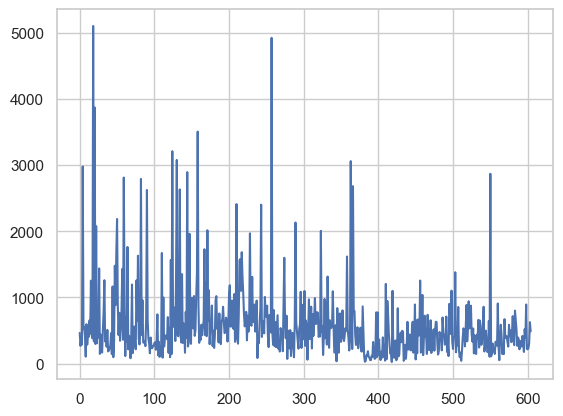

In [99]:
# length distribution of each poem

line_lengths = [len(poem) for poem in dff['cleaned']]
plt.plot(line_lengths)
plt.show()

In [100]:
ttt = pd.DataFrame(line_lengths)
print(ttt.describe())
print(ttt.mode())

                 0
count   605.000000
mean    585.735537
std     585.708873
min      25.000000
25%     269.000000
50%     436.000000
75%     668.000000
max    5102.000000
     0
0  499


__Disparity in length of the poems could be an issue. Investigate with closer length range. Get poems of length close to the mean and 75% quartile__

In [122]:
new_dff = dff

seive = (new_dff['cleaned'].str.len() >= 350) & (new_dff['cleaned'].str.len() <= 1000)

new_dff = new_dff.loc[seive]

new_dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 604
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Science  304 non-null    int64 
 1   cleaned  304 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.1+ KB


In [123]:
print('Total Number of Scientific Poems: ', len(new_dff.loc[new_dff['Science'] == 1])) 
print('Total Number of Non-Scientific Poems: ', len(new_dff.loc[new_dff['Science'] == 0]))

Total Number of Scientific Poems:  246
Total Number of Non-Scientific Poems:  58


__Perform DBSCAN on truncated dataset: Experiment D)__

In [124]:
# perform clustering on the subset

all_poems_as_list = new_dff['cleaned'].to_list()
all_vectors = vectorizer.fit_transform(all_poems_as_list)
all_simi_matrix = cosine_similarity(all_vectors)

labels_all = dbscan.fit_predict(all_simi_matrix)

unique_poems_labels = set(labels_all)
no_poems_clusters = len(np.unique(unique_poems_labels))
no_poems_noise = np.sum(np.array(unique_poems_labels) == -1, axis=0)

print(f'Number of clusters: {no_poems_clusters}')
print(f'Number of noise points: {no_poems_noise}')

Number of clusters: 1
Number of noise points: 0


__Still one cluster__


# KMeans Clustering

__Vectorize the poems__

In [21]:
# vectorize
poems_as_list = df['cleaned'].to_list()
vectorizer = TfidfVectorizer(ngram_range=(1,3))
X = vectorizer.fit_transform(poems_as_list)

__Find the ultimate `k` using the `elbow method`__

In [22]:
# kmeans
from sklearn.cluster import KMeans

In [25]:
sum_of_sqd_distance = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_sqd_distance.append(km.inertia_)

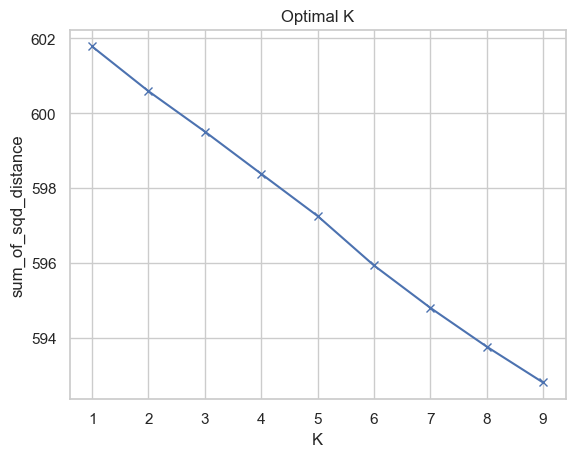

In [26]:
plt.plot(K, sum_of_sqd_distance, 'bx-')
plt.xlabel('K')
plt.ylabel('sum_of_sqd_distance')
plt.title('Optimal K')
plt.show()

__Try an experimental `k = 5` (Experiment E)__

In [36]:
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(X)

for i in range(8):
    cluster_samples = [poems_as_list[j] for j, label in enumerate(labels) if label == i]
    print(f"Cluster {i}:")
    print(len(cluster_samples))
#     print(cluster_samples)
    indices = []
    for p in cluster_samples:
        ii_df = df.loc[df['cleaned'] == p]
        indices.append(list(ii_df.index.values)[0])
    print(indices)
    print()

Cluster 0:
129
[1, 7, 13, 14, 36, 37, 39, 40, 42, 43, 44, 50, 52, 54, 60, 62, 65, 73, 75, 76, 81, 87, 101, 104, 105, 108, 119, 122, 125, 129, 141, 142, 146, 148, 151, 156, 158, 159, 163, 166, 192, 196, 197, 199, 203, 204, 208, 214, 218, 237, 239, 243, 250, 253, 256, 259, 264, 266, 268, 272, 274, 277, 279, 280, 294, 297, 298, 310, 314, 315, 321, 323, 329, 336, 343, 345, 347, 352, 354, 357, 358, 359, 360, 363, 364, 369, 371, 372, 387, 388, 394, 396, 400, 401, 405, 407, 411, 426, 427, 433, 442, 445, 450, 457, 462, 470, 476, 477, 489, 492, 497, 499, 500, 502, 504, 510, 512, 517, 520, 528, 553, 557, 572, 577, 580, 581, 586, 587, 595]

Cluster 1:
181
[12, 16, 20, 21, 23, 28, 29, 30, 31, 35, 45, 46, 51, 53, 55, 57, 58, 70, 72, 79, 86, 88, 89, 91, 93, 94, 100, 103, 111, 123, 128, 132, 133, 134, 145, 150, 152, 154, 155, 165, 168, 172, 174, 175, 178, 180, 184, 186, 187, 189, 191, 194, 200, 202, 210, 213, 222, 224, 225, 231, 232, 238, 241, 245, 249, 251, 255, 258, 262, 263, 265, 267, 269, 271, 27

In [37]:
cluster_0 = [1, 7, 13, 14, 36, 37, 39, 40, 42, 43, 44, 50, 52, 54, 60, 62, 65, 73, 75, 76, 81, 87, 101, 104, 105, 108, 119, 122, 125, 129, 141, 142, 146, 148, 151, 156, 158, 159, 163, 166, 192, 196, 197, 199, 203, 204, 208, 214, 218, 237, 239, 243, 250, 253, 256, 259, 264, 266, 268, 272, 274, 277, 279, 280, 294, 297, 298, 310, 314, 315, 321, 323, 329, 336, 343, 345, 347, 352, 354, 357, 358, 359, 360, 363, 364, 369, 371, 372, 387, 388, 394, 396, 400, 401, 405, 407, 411, 426, 427, 433, 442, 445, 450, 457, 462, 470, 476, 477, 489, 492, 497, 499, 500, 502, 504, 510, 512, 517, 520, 528, 553, 557, 572, 577, 580, 581, 586, 587, 595]

In [40]:
df.iloc[cluster_0]

,Science,cleaned
1,0,was first fruit battle missionary ridge felt ...
7,0,england would bear this heavy servitude one mo...
13,0,pieria wedded blissof time memory mus cameto m...
14,0,band silk minivermomently grew heavier black ...
36,0,motion gathering loop water must either burst ...
...,...,...
580,1,broken controlsexisting firewall rulesare inef...
581,1,evening shortly sunset darkness cover land mys...
586,1,truly poem laboratory one many young scientist...
587,1,love lotlike physic take studyto understandho...


In [30]:
cluster_1 = [12, 16, 20, 21, 23, 28, 29, 30, 31, 35, 45, 46, 51, 53, 55, 57, 58, 70, 72, 79, 86, 88, 89, 91, 93, 94, 100, 103, 111, 123, 128, 132, 133, 134, 145, 150, 152, 154, 155, 165, 168, 172, 174, 175, 178, 180, 184, 186, 187, 189, 191, 194, 200, 202, 210, 213, 222, 224, 225, 231, 232, 238, 241, 245, 249, 251, 255, 258, 262, 263, 265, 267, 269, 271, 275, 276, 278, 281, 283, 285, 288, 295, 304, 311, 316, 317, 325, 327, 328, 331, 332, 333, 335, 337, 340, 341, 342, 344, 346, 348, 349, 350, 355, 356, 361, 362, 365, 367, 373, 374, 376, 377, 379, 382, 383, 392, 395, 408, 409, 410, 415, 416, 419, 421, 425, 434, 435, 436, 438, 439, 440, 443, 446, 447, 451, 455, 456, 458, 461, 466, 474, 478, 480, 483, 484, 485, 487, 493, 494, 501, 511, 515, 516, 522, 524, 532, 533, 534, 536, 546, 548, 552, 555, 559, 562, 563, 564, 566, 569, 571, 573, 574, 575, 576, 588, 590, 592, 594, 600, 601, 603]

df.iloc[cluster_1]

,Science,cleaned
12,0,remember plain heroic strengthand shining virt...
16,0,come house cave tree facing sheer sky everythi...
20,0,mind ha shown timestoo much baked labeled doug...
21,0,spring world mud luscious littlelame balloon m...
23,0,living mightto make hear inmost night near no ...
...,...,...
592,1,another biology poem collectionetry short pros...
594,1,another fine astronomy poem writing north norf...
600,1,poem us mathematics end best poetry blog cosmo...
601,1,gin body meet body flyin air gin body hit body...


__Let's try with 2 clusters since there are two classes of poems (Experiment F)__

In [45]:
kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X)

C:\Users\molab\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
for i in range(3):
    cluster_samples = [poems_as_list[j] for j, label in enumerate(labels) if label == i]
    print(f"Cluster {i}:")
    print(len(cluster_samples))
#     print(cluster_samples)
    indices = []
    for p in cluster_samples:
        ii_df = df.loc[df['cleaned'] == p]
        indices.append(list(ii_df.index.values)[0])
    print(indices)
    print()

Cluster 0:
85
[8, 15, 25, 26, 28, 34, 45, 59, 63, 65, 69, 72, 80, 83, 89, 100, 106, 109, 116, 121, 125, 126, 131, 136, 139, 145, 146, 152, 160, 186, 189, 197, 205, 208, 213, 227, 229, 230, 240, 249, 259, 260, 264, 279, 287, 313, 314, 326, 343, 369, 371, 373, 374, 383, 384, 385, 390, 393, 402, 406, 428, 429, 431, 436, 439, 442, 452, 454, 457, 479, 481, 489, 490, 491, 500, 505, 515, 528, 551, 558, 564, 565, 580, 586, 587]

Cluster 1:
520
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 64, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 122, 123, 124, 127, 128, 129, 130, 132, 133, 134, 135, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158

__Get the number of scientific and non-scientific poems in both clusters__

In [47]:
cluster_00 = [8, 15, 25, 26, 28, 34, 45, 59, 63, 65, 69, 72, 80, 83, 89, 100, 106, 109, 116, 121, 125, 126, 131, 136, 139, 145, 146, 152, 160, 186, 189, 197, 205, 208, 213, 227, 229, 230, 240, 249, 259, 260, 264, 279, 287, 313, 314, 326, 343, 369, 371, 373, 374, 383, 384, 385, 390, 393, 402, 406, 428, 429, 431, 436, 439, 442, 452, 454, 457, 479, 481, 489, 490, 491, 500, 505, 515, 528, 551, 558, 564, 565, 580, 586, 587]
cluster_01 = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 64, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 122, 123, 124, 127, 128, 129, 130, 132, 133, 134, 135, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 206, 207, 209, 210, 211, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 250, 251, 252, 253, 254, 255, 256, 257, 258, 261, 262, 263, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 370, 372, 375, 376, 377, 378, 379, 380, 381, 382, 386, 387, 388, 389, 391, 392, 394, 395, 396, 397, 398, 399, 400, 401, 403, 404, 405, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 430, 432, 433, 434, 435, 437, 438, 440, 441, 443, 444, 445, 446, 447, 448, 449, 450, 451, 453, 455, 456, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 480, 482, 483, 484, 485, 486, 487, 488, 492, 493, 494, 495, 496, 497, 498, 499, 501, 502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 513, 514, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 552, 553, 554, 555, 556, 557, 559, 560, 561, 562, 563, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 581, 582, 583, 584, 585, 588, 589, 590, 591, 592, 593, 594, 595, 596, 570, 449, 599, 600, 601, 448, 603, 604]


cluster0_df = df.iloc[cluster_00]
cluster1_df = df.iloc[cluster_01]

In [53]:
# cluster0_df['Science'].unique().value_counts

print('Total Number of Scientific Poems in Cluster 0: ', len(cluster0_df.loc[cluster0_df['Science'] == 1])) 
print('Total Number of Non-Scientific Poems in Cluster 0: ', len(cluster0_df.loc[cluster0_df['Science'] == 0]))

print('Total Number of Scientific Poems in Cluster 1: ', len(cluster1_df.loc[cluster1_df['Science'] == 1])) 
print('Total Number of Non-Scientific Poems in Cluster 1: ', len(cluster1_df.loc[cluster1_df['Science'] == 0]))


Total Number of Scientific Poems in Cluster 0:  61
Total Number of Non-Scientific Poems in Cluster 0:  24
Total Number of Scientific Poems in Cluster 1:  407
Total Number of Non-Scientific Poems in Cluster 1:  113


In [49]:
cluster1_df['Science'].unique()

array([0, 1], dtype=int64)

# Topic Modelling with LDA

In [41]:
from sklearn.decomposition import LatentDirichletAllocation

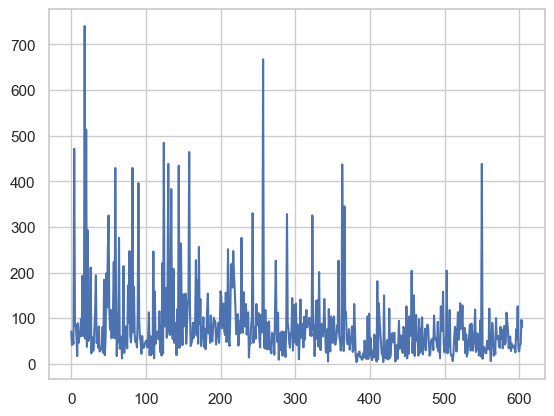

In [42]:
number_of_words = ([len(poem.split()) for poem in df['cleaned']])
plt.plot(number_of_words)
plt.show()

In [43]:
ttt = pd.DataFrame(number_of_words)
print(ttt.describe())
print(ttt.mode())

                0
count  605.000000
mean    82.887603
std     83.933871
min      4.000000
25%     37.000000
50%     61.000000
75%     93.000000
max    740.000000
    0
0  46
1  61
2  67
3  82


__Define stop words, vectorise the poems and define the LDA Model to get the top 10 components (Experiment G)__

In [58]:
stop_words = set(stopwords.words('english'))
all_poems = df['cleaned'].to_list()

vectors = TfidfVectorizer(max_features=1000)
vectorised_poems = vectors.fit_transform(df['cleaned'])

In [59]:
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=42, max_iter=1) 
lda_top = lda_model.fit_transform(vectorised_poems)

In [62]:
lda_top

array([[0.01480963, 0.01480949, 0.01481272, ..., 0.01480939, 0.01481007,
        0.01480946],
       [0.02081109, 0.02081122, 0.02081625, ..., 0.0208113 , 0.0208124 ,
        0.02081114],
       [0.01813423, 0.01813342, 0.01814066, ..., 0.01813382, 0.01813469,
        0.0181336 ],
       ...,
       [0.01620576, 0.01620574, 0.01620722, ..., 0.01620591, 0.01620629,
        0.01620578],
       [0.01493577, 0.01493558, 0.01493753, ..., 0.01493586, 0.01493629,
        0.01493592],
       [0.01521577, 0.01521547, 0.01521754, ..., 0.0152159 , 0.01521549,
        0.01521655]])

In [68]:
for i, topic in enumerate(lda_top[9]):
    print(f"Topic {i}: {topic*100}%")

Topic 0: 1.3653887067860315%
Topic 1: 1.3653590509561688%
Topic 2: 1.365569247872102%
Topic 3: 87.71122357981245%
Topic 4: 1.365468811090567%
Topic 5: 1.3654216159965937%
Topic 6: 1.3653327827719404%
Topic 7: 1.365400658229032%
Topic 8: 1.3654550592534536%
Topic 9: 1.365380487231643%


__Use the `for loop` to print out the topics__

In [73]:
vocab = vectors.get_feature_names_out()

for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print(f"Topic {i}: ")
    words = ""
    for t in sorted_words:
        words += f"{t[0]} "
    print(words)


Topic 0: 
come best poetry cloud one always take and love code 
Topic 1: 
thin rose walked planet sword could song silver side thought 
Topic 2: 
earth life was cell tree like way star many wild 
Topic 3: 
time like light one would space was know star see 
Topic 4: 
lose sea line was came one never god body hand 
Topic 5: 
time moon much look star upon night mass wind one 
Topic 6: 
later seems fallen mean quiet infinity news even near lost 
Topic 7: 
thy girl thou thee earth even cry taste love though 
Topic 8: 
green like science eye was dug back street hand half 
Topic 9: 
de love tube know sense get still one new jump 


In [70]:
lda_model.components_

array([[0.60638202, 0.45340484, 0.44962144, ..., 0.50715977, 0.42298127,
        0.4685082 ],
       [0.49916427, 0.47926562, 0.36033993, ..., 0.45747649, 0.47291819,
        0.56792304],
       [0.63732357, 1.25885648, 0.83597158, ..., 0.64613828, 0.61010983,
        0.5177553 ],
       ...,
       [0.42325014, 0.5026529 , 0.5763496 , ..., 0.64993914, 0.38367154,
        0.45120105],
       [1.07090281, 0.49183131, 0.47391312, ..., 0.58054989, 0.4423173 ,
        0.45056014],
       [0.46034092, 0.42715391, 0.51232696, ..., 0.47930412, 0.46325694,
        0.40785059]])

# Supervised Learning - BERT

In [74]:
!pip install ktrain

In [4]:
import ktrain
from ktrain import text

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Science  605 non-null    int64 
 1   cleaned  605 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


__Check the words and length distribution of the poems__

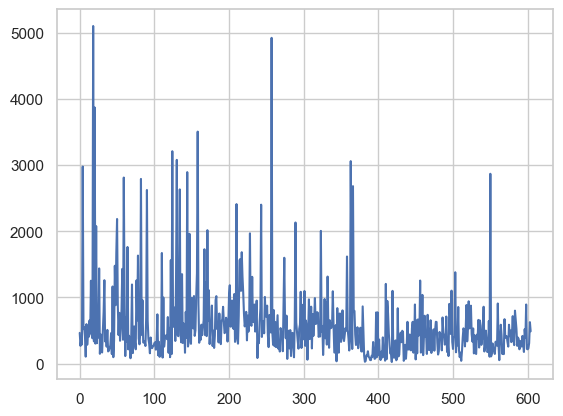

In [78]:
# length distribution
line_lengths = [len(poem) for poem in df['cleaned']]
plt.plot(line_lengths)
plt.show()

In [79]:
ttt = pd.DataFrame(line_lengths)
print(ttt.describe())
print(ttt.mode())

                 0
count   605.000000
mean    585.842975
std     585.700961
min      25.000000
25%     269.000000
50%     436.000000
75%     668.000000
max    5102.000000
     0
0  499


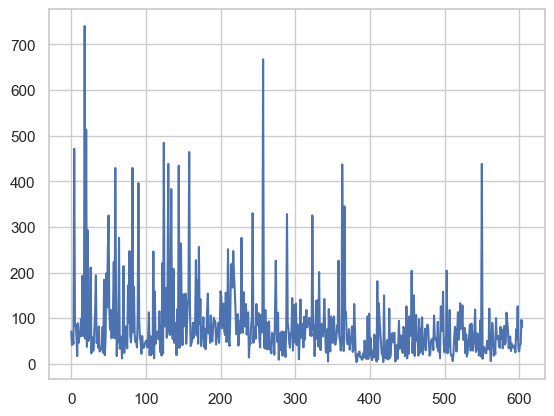

In [80]:
# number of words distribution
number_of_words = ([len(poem.split()) for poem in df['cleaned']])
plt.plot(number_of_words)
plt.show()

In [81]:
ttt_ = pd.DataFrame(number_of_words)
print(ttt_.describe())
print(ttt_.mode())

                0
count  605.000000
mean    82.887603
std     83.933871
min      4.000000
25%     37.000000
50%     61.000000
75%     93.000000
max    740.000000
    0
0  46
1  61
2  67
3  82


__Before experimenting with the whole dataset, let's experiment with the more balanced subset. First, get the word count of poem in the dataset__

In [4]:
new_df = df

new_df['count'] = [len(poem.split()) for poem in new_df['cleaned']]

new_df.sample(10)


,Science,cleaned,count
509,1,cat smart cat wouldrun away since good ill try...,18
283,1,shame audible piece sexual history mouthed gay...,18
134,0,thought was dumb said was dumb yet ive heard...,383
84,0,air gittin cool coolah frost comin de night hi...,169
471,1,specie dying lostor extinction locust pestilen...,22
435,1,machinery the butterfly mainspring thebee h...,9
206,1,perhaps seeis synapse turbulencethin drifting ...,63
553,1,time was han philosophersstanding hilltop nig...,37
83,0,sky great dark cloud massing look far pregnan...,70
62,0,ithe bronze general grant riding bronze horse ...,107


__Create a truncated dataset with word counts between 35 and 130__

In [5]:
seive = (new_df['count'] >= 35) & (new_df['count'] <= 130)

new_df = new_df.loc[seive]

new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 385 entries, 0 to 604
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Science  385 non-null    int64 
 1   cleaned  385 non-null    object
 2   count    385 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 12.0+ KB


In [11]:
#save to csv
new_df.to_csv('truncated-poems.csv', index=False)

In [3]:
new_df = pd.read_csv('truncated-poems.csv')

In [33]:
print('Total Number of Scientific Poems in New DF: ', len(new_df.loc[new_df['Science'] == 1])) 
print('Total Number of Non-Scientific Poems in New DF: ', len(new_df.loc[new_df['Science'] == 0]))

Total Number of Scientific Poems in New DF:  301
Total Number of Non-Scientific Poems in New DF:  84


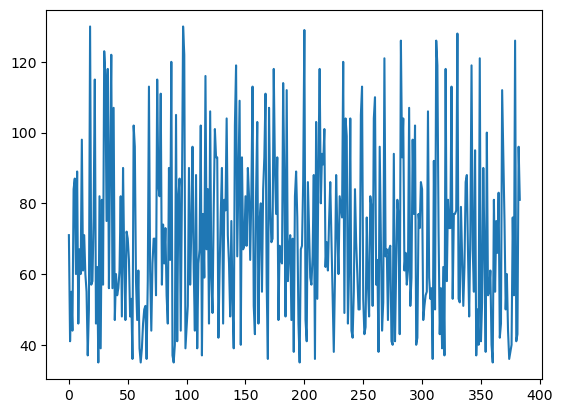

In [8]:
# check the length distribution of the truncated dataset.
# it is more balanced now

number_of_words = ([len(poem.split()) for poem in new_df['cleaned']])
plt.plot(number_of_words)
plt.show()

In [9]:
ttt_ = pd.DataFrame(number_of_words)
print(ttt_.describe())
print(ttt_.mode())

                0
count  384.000000
mean    70.377604
std     24.109425
min     35.000000
25%     51.000000
50%     67.000000
75%     86.000000
max    130.000000
    0
0  46
1  61
2  67
3  82


In [6]:
# split to test and train data

X_train, X_test, y_train, y_test = train_test_split(new_df['cleaned'], new_df['Science'], test_size=0.2, random_state=42)

In [7]:
# convert to list

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [8]:
class_names = ['Non Scientific Poem', 'Scientific Poem']

### Experiment H
__`maxlen = 120, batch size: 16 and epochs = 5`__

In [38]:
# build the bert model

(xx_train, yy_train), (xx_val, yy_val), preproc = text.texts_from_array(x_train = X_train, y_train = y_train,
                                                                        x_test = X_test, y_test = y_test,
                                                                        class_names = class_names,
                                                                        preprocess_mode = 'bert',
                                                                        maxlen=120)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [39]:
bert_model = text.text_classifier('bert', train_data=(xx_train, yy_train), preproc=preproc)

Is Multi-Label? False
maxlen is 120


C:\Users\molab\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


 #### bert learner model with 120 maxlen, bacth size 16 and 5 epochs 

In [25]:
bert_learner = ktrain.get_learner(bert_model, train_data=(xx_train, yy_train), val_data=(xx_val, yy_val), batch_size=16)

In [26]:
bert_learner.fit_onecycle(2e-5, 5)

# save model locally
filename = "bert_model5.joblib"
joblib.dump(bert_learner, filename)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
20/20 [==============================] - 302s 13s/step - loss: 0.4842 - accuracy: 0.8078 - val_loss: 0.6107 - val_accuracy: 0.6753
Epoch 2/5
20/20 [==============================] - 194s 10s/step - loss: 0.3439 - accuracy: 0.8404 - val_loss: 0.2383 - val_accuracy: 0.9351
Epoch 3/5
20/20 [==============================] - 197s 10s/step - loss: 0.1823 - accuracy: 0.9218 - val_loss: 0.5308 - val_accuracy: 0.8052
Epoch 4/5
20/20 [==============================] - 196s 10s/step - loss: 0.0778 - accuracy: 0.9739 - val_loss: 0.5350 - val_accuracy: 0.8312
Epoch 5/5
20/20 [==============================] - 196s 10s/step - loss: 0.0459 - accuracy: 0.9805 - val_loss: 0.3001 - val_accuracy: 0.9221


['bert_model5.joblib']

__Plot the Model training and validation losses__

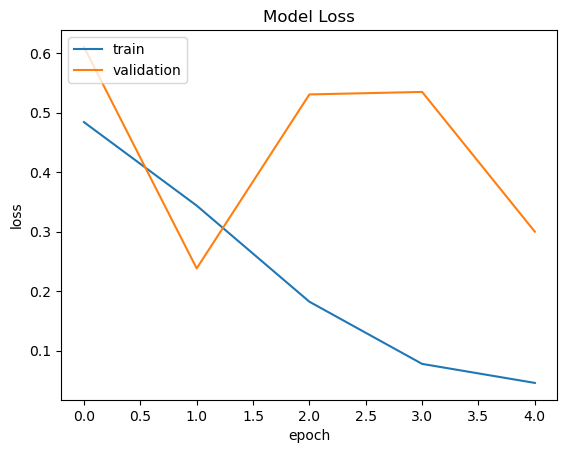

In [27]:
bert_learner.plot()

In [28]:
bert_learner.validate(val_data = (xx_val, yy_val), class_names=class_names)

3/3 [==============================] - 15s 3s/step
                     precision    recall  f1-score   support

Non Scientific Poem       0.91      0.84      0.87        25
    Scientific Poem       0.93      0.96      0.94        52

           accuracy                           0.92        77
          macro avg       0.92      0.90      0.91        77
       weighted avg       0.92      0.92      0.92        77



array([[21,  4],
       [ 2, 50]], dtype=int64)

__Test the model with actual poems__

Nonscience poems are: `test_poem01, test_poem02, test_poem04, and test_poem03`

Science Poems are: `test_poem11, test_poem12, test_poem13 and test_poem14`

Neutral poem: `test_poem_neutral`

In [29]:
bert_predictor = ktrain.get_predictor(bert_learner.model, preproc)
bert_predictor.get_classes()

['Non Scientific Poem', 'Scientific Poem']

In [40]:
test_poem01 = "leaned mantel sick sick thinking failure looking abysm weak noon day heat church bell sounded mournfully far away heard cry baby coughing john yarnell bed ridden feverish feverish dying violent voice wife   watch potato burning  smelled  was irresistible disgust pulled trigger blackness light unspeakable regret fumbling world late thus came lung breathing one breathe lung though one must breatheof use rid one self world soul may ever escape eternal destiny life"

test_poem02 = "little dream england bore me under cotswold hill beside water meadow dreadful service beyond bordersand enfolding sea  was dreamer ever bound dear service meditating deep thought secret beauty child face one may see clear spiritmiraculously shining hill hill friend mine kindly tiny knoll orchard hidden beside rivermuddy strongly flowing shy tiny streamletssafe bosom memory sky rushy sky poolsfragile mirror easily broken moving air deep heart ever go daily us consecrate think mother wrest soul serve youin strange fearful way beyond encircling water  none know heart tear sacrifice  none repay"

test_poem11 = "lived valence band rockstar quantum clan world high conduction band sky destined jump help mankind friend pal already flied left band  was never alone uncle flying pro flying sooner later came homefrom deployed father said energy neither created destroyed  was alone sitting tree waiting turn get free one day dream came told need act whoa  was set fly tried tried tried triedbut bandgap  was pretty high knew one ever flied soloit  was insane dream liked follow one dayi gathered foot ran"

test_poem12 = "cheek  was crown fitted last year extensive root work  hair fine drill clearing every root came two week lockdown four month later im chair different dentist different nurse different x ray scuttle sign decay jaw could nasty numbs lever tooth warns bleeding & e dry socket none happens though stiffnessof jaw unexpected sore throatis nothing strong salt mouthwashcant swill away worry major loss wisdom week ha become obvious g conveys covid world frisbee head full lizard brain"

test_poem_neutral = "Hold fast dreams dreams die Life broken-winged bird cannot fly Hold fast dreams when dreams Life barren field Frozen snow"


print(bert_predictor.predict(test_poem01))

print(bert_predictor.predict(test_poem02))

print(bert_predictor.predict(test_poem11))

print(bert_predictor.predict(test_poem12))

print(bert_predictor.predict(test_poem_neutral))

Non Scientific Poem
Non Scientific Poem
Scientific Poem
Scientific Poem
Non Scientific Poem


In [41]:
test_poem13 = """
Dippy’s advice, adopt the loving diplomatic culture; shown by bonobo’s peaceful irenology (peace study);
thrown aside in favour of more quarrelsome warlike natured chimpanzee.
You are surprised to find; your anthropogenesis (human origin) share monkey DNA;
and from the primordial soup protozoa (primitive fauna), even share some part of me;
but that’s not all; more curious still, to some’s dismay
you have from protophyta (primitive plant), common genealogy with a tree;
the citric acid cycle key in all living organisms as you know them to be.
Man wonders is evolution just Poisson probability? But Gods do not play games of chance;
of cause they do, that’s how all Gods’ physics work and advance.
Too complex; how can a system know what is to come?
Ahh! But how clever to predict the start and ending of a sun;
and adjust the Worlds ecology accordingly;
maybe in my science mind there is yet room for the hand of deity.
Junk DNA men call it but not so, you do ignore;
the library of possibilities therein that lay in store;
subroutines of bits genetic, a self optimising system;
if found illusive starting point, then it can still make me, a dinosaur;
it is blue-print of creatures past; and of all that is to come;
no stumpy camelopard (giraffe) fossil found; junk DNA already knew;
how to make; a TALL one.
"""


print(bert_predictor.predict(test_poem13))

Scientific Poem


In [42]:
test_poem14 = """
Once upon a time, in the year 2023,
Someone asked this poet, in 7023,
What will the world be, 5000 years later,
It took me almost five hours to cater

First is for a baby to understand,
if it cries, will be programmed to stand,
A intelligence chip will be installed
It's past, present, future will be stalled,

The baby will be give fast tracked growth,
Science will decide studies of the north
Years become days, each year will be a day,
Count to thirty days, the baby will stay at thirty

The parents are no longer humans but labs,
Human genes are programmed with dabs,
Grown in scientific human generators,
No fights or fumes, waste or compactors,

The scientists are programmed artificial bots,
Codes, slash, commas strewn with dots,
There are no human-flesh, human beings existing,
They gave more power to robots, now non-existing

There are no more gods or statues or rituals,
They are now a study, programmed in factuals,
In libraries programmed in chips to feed,
Onto the baby grown in labs, during its seeds

There are no schools, colleges or workplaces
No gardens, no leisure spots or tourism in place,
There are no social media or giants to rule people,
Each programmed baby is now a 30 year old sheeple.

There is no disease to cry no is there death,
No food poisoning or air borne or water borne beath,
There are no medicines produced for healing,
Since there are no human beings anymore dwelling.

There are no more rulers to rule or burn,
cities, countries or people, machines to turn,
There is no one iron hand to claime sole power
they were all burned to death with nuclear power.

What remained were nuclear proof machines,
They burned all the human flesh to dust and genes,
Their seeds, from human beings were collected,
No smell of rotting flesh, all disinfected.

Now we have no feelings or emotions,
We are all programmed to fasten emoticons,
There is no more meaning to asking again
What will become 5000 years from that pain.
"""

print(bert_predictor.predict(test_poem14))

Scientific Poem


In [44]:
test_poem03 = """
Now Jones had left his new-wed bride to keep his house in order,
And hied away to the Hurrum Hills above the Afghan border,
To sit on a rock with a heliograph; but ere he left he taught
His wife the working of the Code that sets the miles at naught.

And Love had made him very sage, as Nature made her fair;
So Cupid and Apollo linked , per heliograph, the pair.
At dawn, across the Hurrum Hills, he flashed her counsel wise —
At e'en, the dying sunset bore her husband's homilies.

He warned her 'gainst seductive youths in scarlet clad and gold,
As much as 'gainst the blandishments paternal of the old;
But kept his gravest warnings for (hereby the ditty hangs)
That snowy-haired Lothario, Lieutenant-General Bangs.

'Twas General Bangs, with Aide and Staff, who tittupped on the way,
When they beheld a heliograph tempestuously at play.
They thought of Border risings, and of stations sacked and burnt —
So stopped to take the message down — and this is whay they learnt —

"Dash dot dot, dot, dot dash, dot dash dot" twice. The General swore.
"Was ever General Officer addressed as 'dear' before?
"'My Love,' i' faith! 'My Duck,' Gadzooks! 'My darling popsy-wop!'
"Spirit of great Lord Wolseley, who is on that mountaintop?"

The artless Aide-de-camp was mute; the gilded Staff were still,
As, dumb with pent-up mirth, they booked that message from the hill;
For clear as summer lightning-flare, the husband's warning ran: —
"Don't dance or ride with General Bangs — a most immoral man."

[At dawn, across the Hurrum Hills, he flashed her counsel wise —
But, howsoever Love be blind, the world at large hath eyes.]
With damnatory dot and dash he heliographed his wife
Some interesting details of the General's private life.

The artless Aide-de-camp was mute, the shining Staff were still,
And red and ever redder grew the General's shaven gill.
And this is what he said at last (his feelings matter not): —
"I think we've tapped a private line. Hi! Threes about there! Trot!"

All honour unto Bangs, for ne'er did Jones thereafter know
By word or act official who read off that helio.
But the tale is on the Frontier, and from Michni to Mooltan
They know the worthy General as "that most immoral man."
"""

print(bert_predictor.predict(test_poem03))

Non Scientific Poem


In [26]:
test_poem04 = """
Every tears shed from these eyes,
every pain that this body endures.
Every last drops of rain that sank through the land
and every lost words that will never be spoken again.

Time flies, living through the pain,
though the smile will never be the same again.
No more tears, the pain seems to clear the game,
never mean it won't ever haunt again.

Relieving by its very nature from sorrow,
the twisted fate has emerge from the shadow.
A piece of sand paper became the first chapter,
'counting worms' set off to be the game setter.
"""

print(bert_predictor.predict(test_poem04))

In [46]:
# loaded_model = joblib.load(filename)
# result = loaded_model.score(X_test, y_test)
# print(result)

 ### Experiment I
 
 `120 maxlen, bacth size 16 and 10 epochs`

In [47]:
bert10_learner = ktrain.get_learner(bert_model, train_data=(xx_train, yy_train), val_data=(xx_val, yy_val), batch_size=16)

In [48]:
bert10_learner.fit_onecycle(2e-5, 10)

filename = "bert_model10.joblib"
joblib.dump(bert10_learner, filename)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
20/20 [==============================] - 219s 10s/step - loss: 1.0249 - accuracy: 0.5325 - val_loss: 0.8955 - val_accuracy: 0.6753
Epoch 2/10
20/20 [==============================] - 193s 10s/step - loss: 0.3258 - accuracy: 0.8864 - val_loss: 0.3676 - val_accuracy: 0.8312
Epoch 3/10
20/20 [==============================] - 193s 10s/step - loss: 0.2457 - accuracy: 0.8994 - val_loss: 0.1747 - val_accuracy: 0.9351
Epoch 4/10
20/20 [==============================] - 188s 9s/step - loss: 0.1774 - accuracy: 0.9383 - val_loss: 0.3470 - val_accuracy: 0.8701
Epoch 5/10
20/20 [==============================] - 186s 9s/step - loss: 0.0751 - accuracy: 0.9805 - val_loss: 0.2777 - val_accuracy: 0.9221
Epoch 6/10
20/20 [==============================] - 187s 9s/step - loss: 0.0351 - accuracy: 0.9935 - val_loss: 0.2672 - val_accuracy: 0.9481
Epoch 7/10
20/20 [==============================] - 186s 9s/step - loss: 0.0188 - accura

['bert_model10.joblib']

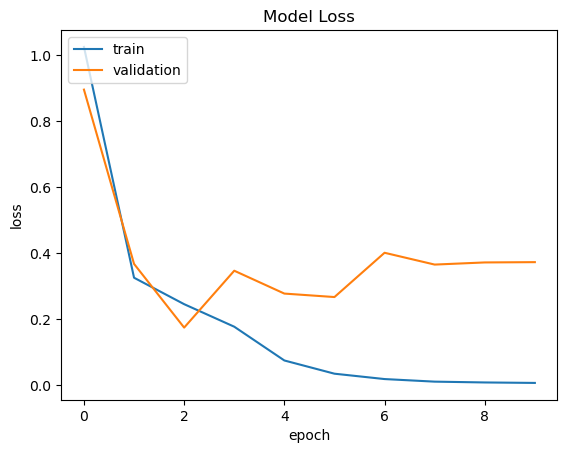

In [49]:
# plot the training and validation losses 

bert10_learner.plot()

In [50]:
bert10_learner.validate(val_data = (xx_val, yy_val), class_names=class_names)

3/3 [==============================] - 15s 3s/step
                     precision    recall  f1-score   support

Non Scientific Poem       0.95      0.80      0.87        25
    Scientific Poem       0.91      0.98      0.94        52

           accuracy                           0.92        77
          macro avg       0.93      0.89      0.91        77
       weighted avg       0.92      0.92      0.92        77



array([[20,  5],
       [ 1, 51]], dtype=int64)

In [51]:
bert10_predictor = ktrain.get_predictor(bert10_learner.model, preproc)
bert10_predictor.get_classes()

['Non Scientific Poem', 'Scientific Poem']

In [52]:
print("========Should all be Non Scientic========")

print(bert10_predictor.predict(test_poem01))

print(bert10_predictor.predict(test_poem02))

print(bert10_predictor.predict(test_poem03))

print(bert10_predictor.predict(test_poem04))


print("========Should all be Scientic========")


print(bert10_predictor.predict(test_poem11))

print(bert10_predictor.predict(test_poem12))

print(bert10_predictor.predict(test_poem13))

print(bert10_predictor.predict(test_poem14))


print("========Could be Either========")


print(bert_predictor.predict(test_poem_neutral))

========Should all be Non Scientic========
Scientific Poem
Non Scientific Poem
Non Scientific Poem
Scientific Poem
========Should all be Scientic========
Scientific Poem
Scientific Poem
Scientific Poem
Scientific Poem
========Could be Either========
Non Scientific Poem


 ### Experiment J: 
 
 #### (Entire dataset will be used, maximum length will be set to 150)
 
 `150 maxlen, bacth size 32 and 7 epochs`

In [5]:
# split to test and train data

X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['Science'], test_size=0.2, random_state=42, stratify= df['Science'])

In [6]:
# convert to list

X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [7]:
class_names = class_names = ['Non Scientific Poem', 'Scientific Poem']

# build the bert model

(xx_train, yy_train), (xx_val, yy_val), preproc = text.texts_from_array(x_train = X_train, y_train = y_train,
                                                                        x_test = X_test, y_test = y_test,
                                                                        class_names = class_names,
                                                                        preprocess_mode = 'bert',
                                                                        maxlen=150)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [8]:
bert02_5_model = text.text_classifier('bert', train_data=(xx_train, yy_train), preproc=preproc)

Is Multi-Label? False
maxlen is 150


C:\Users\molab\anaconda3\lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [9]:
bert02_5_learner = ktrain.get_learner(bert02_5_model, train_data=(xx_train, yy_train), val_data=(xx_val, yy_val), batch_size=16)

In [10]:
# train bert model

bert02_5_learner.fit_onecycle(2e-5, 7)

filename = "bert02_5_model5.joblib"
joblib.dump(bert02_5_learner, filename)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/7
31/31 [==============================] - 406s 12s/step - loss: 0.4967 - accuracy: 0.7748 - val_loss: 0.3874 - val_accuracy: 0.7934
Epoch 2/7
31/31 [==============================] - 371s 12s/step - loss: 0.3075 - accuracy: 0.8678 - val_loss: 0.2427 - val_accuracy: 0.9008
Epoch 3/7
31/31 [==============================] - 376s 12s/step - loss: 0.1896 - accuracy: 0.9298 - val_loss: 0.3258 - val_accuracy: 0.8843
Epoch 4/7
31/31 [==============================] - 376s 12s/step - loss: 0.1216 - accuracy: 0.9525 - val_loss: 0.2525 - val_accuracy: 0.8843
Epoch 5/7
31/31 [==============================] - 3618s 120s/step - loss: 0.0569 - accuracy: 0.9835 - val_loss: 0.2860 - val_accuracy: 0.9174
Epoch 6/7
31/31 [==============================] - 372s 12s/step - loss: 0.0228 - accuracy: 0.9959 - val_loss: 0.2771 - val_accuracy: 0.9091
Epoch 7/7
31/31 [==============================] - 395s 13s/step - loss: 0.0139 - accurac

['bert02_5_model5.joblib']

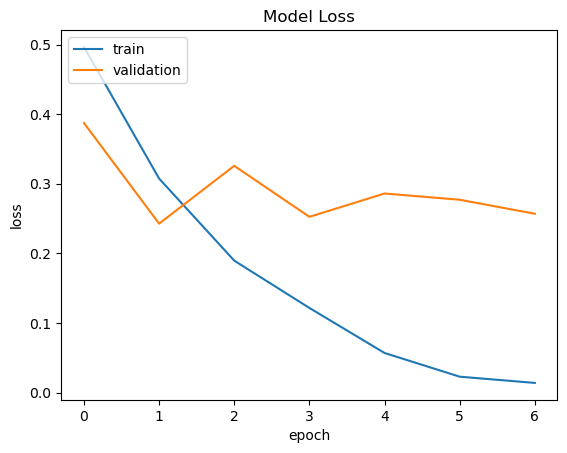

In [12]:
# plot the training and validation losses

bert02_5_learner.plot()

In [13]:
bert02_5_learner.validate(val_data = (xx_val, yy_val), class_names=class_names)

4/4 [==============================] - 32s 7s/step
                     precision    recall  f1-score   support

Non Scientific Poem       0.88      0.85      0.87        27
    Scientific Poem       0.96      0.97      0.96        94

           accuracy                           0.94       121
          macro avg       0.92      0.91      0.92       121
       weighted avg       0.94      0.94      0.94       121



array([[23,  4],
       [ 3, 91]], dtype=int64)

In [14]:
bert02_5_predictor = ktrain.get_predictor(bert02_5_learner.model, preproc)
bert02_5_predictor.get_classes()

['Non Scientific Poem', 'Scientific Poem']

In [18]:
print("========Should all be Non Scientic========")

print(bert02_5_predictor.predict(test_poem01))

print(bert02_5_predictor.predict(test_poem02))

print(bert02_5_predictor.predict(test_poem03))

print(bert02_5_predictor.predict(test_poem04))


print("========Should all be Scientic========")


print(bert02_5_predictor.predict(test_poem11))

print(bert02_5_predictor.predict(test_poem12))

print(bert02_5_predictor.predict(test_poem13))

print(bert02_5_predictor.predict(test_poem14))


print("========Could be Either========")


print(bert02_5_predictor.predict(test_poem_neutral))

========Should all be Non Scientic========
Non Scientific Poem
Non Scientific Poem
Non Scientific Poem
Scientific Poem
========Should all be Scientic========
Scientific Poem
Scientific Poem
Scientific Poem
Scientific Poem
========Could be Either========
Scientific Poem


# Bi-directional LSTM 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Science  605 non-null    int64 
 1   cleaned  605 non-null    object
 2   count    605 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 14.3+ KB


In [10]:
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D, Flatten, MaxPooling1D, Conv1D
from keras.preprocessing.text import Tokenizer

In [4]:
# split into test and train datasets

X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['Science'], test_size=0.2, random_state=42, stratify= df['Science'])

#### Tokenize Text

__Use fit_on_text() to update the internal vocabulary based on the text.__

__Use text_to_sequences() to transform the text to a sequence of integers__

__Calculate the `vocab_size` based on the length of the tokenizer__

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(x_train, maxlen=150, padding='post')
x_test = pad_sequences(x_test, maxlen=150, padding='post')
y_train = np.array(y_train)
y_test = np.array(y_test)

### Experiment K

`one embedding layer, one BiLSTM layer`

In [29]:
# build sequential model

bilstm_model = Sequential()
bilstm_model.add(Embedding(vocab_size, 16, input_length=150))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(1, activation='sigmoid'))
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 16)           225984    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              41472     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 267,585
Trainable params: 267,585
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model training 

bilstm_history = bilstm_model.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=[x_test, y_test])

Epoch 1/15
16/16 [==============================] - 7s 136ms/step - loss: 0.6191 - accuracy: 0.7665 - val_loss: 0.5600 - val_accuracy: 0.7769
Epoch 2/15
16/16 [==============================] - 1s 79ms/step - loss: 0.5084 - accuracy: 0.7727 - val_loss: 0.5223 - val_accuracy: 0.7769
Epoch 3/15
16/16 [==============================] - 1s 79ms/step - loss: 0.4851 - accuracy: 0.7727 - val_loss: 0.4933 - val_accuracy: 0.7769
Epoch 4/15
16/16 [==============================] - 1s 77ms/step - loss: 0.3605 - accuracy: 0.8306 - val_loss: 0.3703 - val_accuracy: 0.8760
Epoch 5/15
16/16 [==============================] - 1s 77ms/step - loss: 0.1663 - accuracy: 0.9752 - val_loss: 0.3531 - val_accuracy: 0.8264
Epoch 6/15
16/16 [==============================] - 1s 89ms/step - loss: 0.0797 - accuracy: 0.9897 - val_loss: 0.2503 - val_accuracy: 0.8926
Epoch 7/15
16/16 [==============================] - 1s 79ms/step - loss: 0.0443 - accuracy: 0.9959 - val_loss: 0.3201 - val_accuracy: 0.8760
Epoch 8/15
1

In [34]:
# print loss and accuracy

print(bilstm_history.history['loss'])
print(bilstm_history.history['accuracy'])

[0.6190687417984009, 0.5083987712860107, 0.4851212799549103, 0.36048242449760437, 0.16631534695625305, 0.07967023551464081, 0.04434872046113014, 0.06234487146139145, 0.044942982494831085, 0.01668914407491684, 0.017773684114217758, 0.012041297741234303, 0.012753866612911224, 0.13256259262561798, 0.06817168742418289]
[0.7665289044380188, 0.7727272510528564, 0.7727272510528564, 0.8305785059928894, 0.9752066135406494, 0.9896694421768188, 0.9958677887916565, 0.9855371713638306, 0.9958677887916565, 1.0, 0.9979338645935059, 1.0, 0.9979338645935059, 0.9834710955619812, 0.9979338645935059]


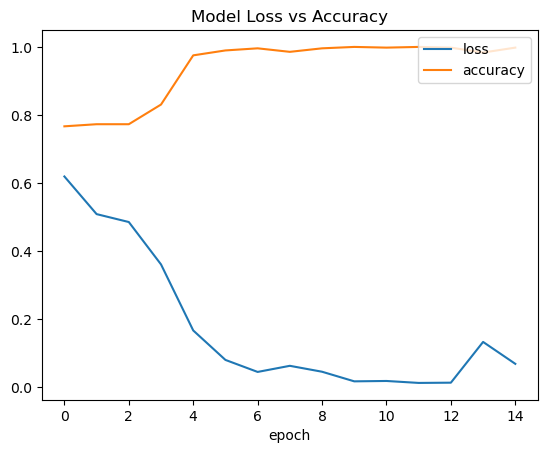

In [36]:
# plot the model loss and accuracy to the number of epochs used

plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['accuracy'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

In [54]:
# write a function to predict the model

def predict_text(text, model):
    x_text = tokenizer.texts_to_sequences(text)
    xx_text = pad_sequences(x_text, maxlen=150, padding='post')
    yyy_predd = model.predict(xx_text)
    print(np.argmax(yyy_predd))
    pred_sci = yyy_predd[0]
    print(f'pred sci : {pred_sci}')
    pred_class = 1 if pred_sci >= 0.5 else 0
    print(f'pred class: {pred_class}')

In [56]:
print("========Should all be Non Scientic========")

predict_text(test_poem01, bilstm_model)

predict_text(test_poem02, bilstm_model)

predict_text(test_poem03, bilstm_model)

predict_text(test_poem04, bilstm_model)

print("========Should all be Scientic========")

predict_text(test_poem11, bilstm_model)

predict_text(test_poem12, bilstm_model)

predict_text(test_poem13, bilstm_model)

predict_text(test_poem14, bilstm_model)

print("========Could be Either========")

predict_text(test_poem_neutral, bilstm_model)

========Should all be Non Scientic========
15/15 [==============================] - 0s 25ms/step
38
pred sci : [0.94165623]
pred class: 1
19/19 [==============================] - 0s 25ms/step
8
pred sci : [0.94165623]
pred class: 1
70/70 [==============================] - 2s 26ms/step
33
pred sci : [0.9440506]
pred class: 1
17/17 [==============================] - 0s 27ms/step
4
pred sci : [0.9440506]
pred class: 1
========Should all be Scientic========
16/16 [==============================] - 0s 25ms/step
19
pred sci : [0.94165623]
pred class: 1
15/15 [==============================] - 0s 25ms/step
12
pred sci : [0.94427174]
pred class: 1
42/42 [==============================] - 1s 25ms/step
50
pred sci : [0.9440506]
pred class: 1
61/61 [==============================] - 2s 28ms/step
29
pred sci : [0.9440506]
pred class: 1
========Could be Either========
4/4 [==============================] - 0s 23ms/step
11
pred sci : [0.95070463]
pred class: 1


__Let's try more layers and try again - Bi-LSTM only__

### Experiment L

`one embedidng layer, spatialdropout layer, two bilstm layers`

In [16]:
b_lstm_model = Sequential()
b_lstm_model.add(Embedding(vocab_size, 64, input_length=150, trainable=False))
b_lstm_model.add(SpatialDropout1D(0.6))

b_lstm_model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_model.add(Dropout(0.3))

b_lstm_model.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
b_lstm_model.add(Dropout(0.3))

b_lstm_model.add(Flatten())
b_lstm_model.add(Dense(64, activation='relu'))
b_lstm_model.add(Dropout(0.4))
b_lstm_model.add(Dense(1, activation='sigmoid'))

b_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 64)           903936    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 150, 64)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_6 (Bidirectio  (None, 150, 200)         132000    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 150, 200)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 600)              1202400   
 nal)                                                            
                                                      

In [17]:
# model training

b_lstm_model_history = b_lstm_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=[x_test, y_test])

Epoch 1/10
16/16 [==============================] - 123s 7s/step - loss: 0.5709 - acc: 0.7603 - val_loss: 0.5475 - val_acc: 0.7769
Epoch 2/10
16/16 [==============================] - 129s 8s/step - loss: 0.5398 - acc: 0.7727 - val_loss: 0.5425 - val_acc: 0.7769
Epoch 3/10
16/16 [==============================] - 130s 8s/step - loss: 0.5607 - acc: 0.7707 - val_loss: 0.5287 - val_acc: 0.7769
Epoch 4/10
16/16 [==============================] - 139s 9s/step - loss: 0.5187 - acc: 0.7769 - val_loss: 0.5363 - val_acc: 0.7769
Epoch 5/10
16/16 [==============================] - 143s 9s/step - loss: 0.5306 - acc: 0.7645 - val_loss: 0.5270 - val_acc: 0.7603
Epoch 6/10
16/16 [==============================] - 128s 8s/step - loss: 0.5252 - acc: 0.7831 - val_loss: 0.5448 - val_acc: 0.7769
Epoch 7/10
16/16 [==============================] - 137s 9s/step - loss: 0.5321 - acc: 0.7707 - val_loss: 0.5351 - val_acc: 0.7769
Epoch 8/10
16/16 [==============================] - 131s 8s/step - loss: 0.5400 - a

In [18]:
# save model locally 

filename = "b_lstm_model.joblib"
joblib.dump(b_lstm_model, filename)

['b_lstm_model.joblib']

In [20]:
print(b_lstm_model_history.history['loss'])
print(b_lstm_model_history.history['acc'])

[0.5708978176116943, 0.5397998690605164, 0.5607146620750427, 0.5187227129936218, 0.5305739641189575, 0.525208592414856, 0.5321189165115356, 0.5399789810180664, 0.5264546871185303, 0.5198251008987427]
[0.7603305578231812, 0.7727272510528564, 0.7706611752510071, 0.7768595218658447, 0.7644628286361694, 0.7830578684806824, 0.7706611752510071, 0.7747933864593506, 0.7727272510528564, 0.7727272510528564]


In [21]:
b_lstm_model_evaluation = b_lstm_model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_model_evaluation[0]}; Accuracy: {100*b_lstm_model_evaluation[1]}%")

Loss: 0.5274275541305542; Accuracy: 76.03305578231812%


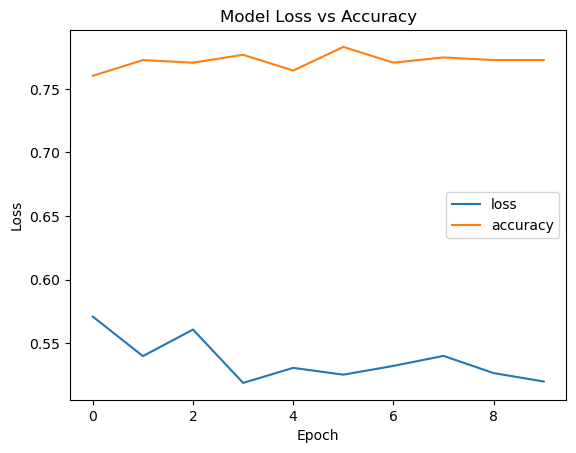

In [23]:
# plot training loss and accuracy against number of epochs

plt.plot(b_lstm_model_history.history['loss'])
plt.plot(b_lstm_model_history.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()

__Let's train with trainable embedding parameters__

### Experiment M

`one trainable embedding layer, spatialdropout layer, 2 bilstm layers`

In [24]:
b_lstm_model2 = Sequential()
b_lstm_model2.add(Embedding(vocab_size, 64, input_length=150))
b_lstm_model2.add(SpatialDropout1D(0.6))

b_lstm_model2.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_model2.add(Dropout(0.3))

b_lstm_model2.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
b_lstm_model2.add(Dropout(0.3))

b_lstm_model2.add(Flatten())
b_lstm_model2.add(Dense(64, activation='relu'))
b_lstm_model2.add(Dropout(0.4))
b_lstm_model2.add(Dense(1, activation='sigmoid'))

b_lstm_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 64)           903936    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 150, 64)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_8 (Bidirectio  (None, 150, 200)         132000    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 150, 200)          0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 600)              1202400   
 nal)                                                            
                                                      

In [25]:
b_lstm_model_history2 = b_lstm_model2.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=[x_test, y_test])

Epoch 1/10
16/16 [==============================] - 167s 10s/step - loss: 0.6333 - acc: 0.7645 - val_loss: 0.5565 - val_acc: 0.7769
Epoch 2/10
16/16 [==============================] - 132s 8s/step - loss: 0.5341 - acc: 0.7727 - val_loss: 0.5292 - val_acc: 0.7769
Epoch 3/10
16/16 [==============================] - 134s 8s/step - loss: 0.5148 - acc: 0.7727 - val_loss: 0.5209 - val_acc: 0.7769
Epoch 4/10
16/16 [==============================] - 138s 9s/step - loss: 0.4300 - acc: 0.8450 - val_loss: 0.3594 - val_acc: 0.8595
Epoch 5/10
16/16 [==============================] - 137s 9s/step - loss: 0.1516 - acc: 0.9483 - val_loss: 0.2782 - val_acc: 0.9008
Epoch 6/10
16/16 [==============================] - 139s 9s/step - loss: 0.0607 - acc: 0.9814 - val_loss: 0.2431 - val_acc: 0.9174
Epoch 7/10
16/16 [==============================] - 142s 9s/step - loss: 0.0375 - acc: 0.9897 - val_loss: 0.3894 - val_acc: 0.8430
Epoch 8/10
16/16 [==============================] - 136s 8s/step - loss: 0.0263 - 

In [26]:
b_lstm_model2_evaluation = b_lstm_model2.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_model2_evaluation[0]}; Accuracy: {100*b_lstm_model2_evaluation[1]}%")

Loss: 0.44995734095573425; Accuracy: 90.08264541625977%


In [27]:
filename = "b_lstm_model2.joblib"
joblib.dump(b_lstm_model2, filename)

['b_lstm_model2.joblib']

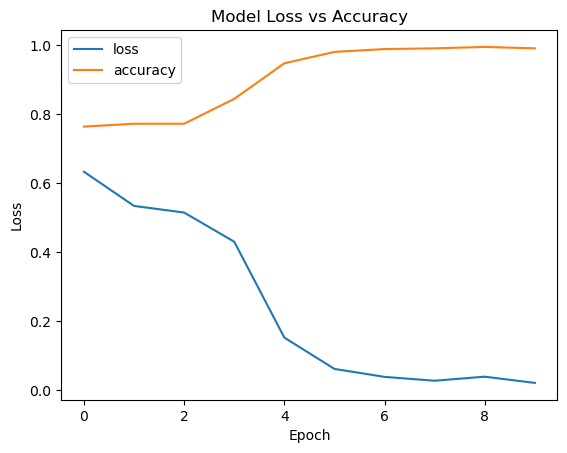

In [28]:
plt.plot(b_lstm_model_history2.history['loss'])
plt.plot(b_lstm_model_history2.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()

# BI-LSTM + CNN

### Experiment N

`One embedding layer, spatial dropout layer, 2 Conv1D+MaxPooling1D layers, 2 bilstm layers`

In [14]:
b_lstm_cnn_model = Sequential()
b_lstm_cnn_model.add(Embedding(vocab_size, 64, input_length=150, trainable=False))
b_lstm_cnn_model.add(SpatialDropout1D(0.6))

b_lstm_cnn_model.add(Conv1D(filters=150, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model.add(Conv1D(filters=200, kernel_size=6, activation='relu'))
b_lstm_cnn_model.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model.add(Bidirectional(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model.add(Dropout(0.3))

b_lstm_cnn_model.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
b_lstm_cnn_model.add(Dropout(0.3))

b_lstm_cnn_model.add(Flatten())
b_lstm_cnn_model.add(Dense(64, activation='relu'))
b_lstm_cnn_model.add(Dropout(0.4))
b_lstm_cnn_model.add(Dense(1, activation='sigmoid'))

b_lstm_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 64)           903936    
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 150, 64)          0         
 lDropout1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 150, 150)          57750     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 75, 150)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 70, 200)           180200    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 35, 200)         

In [15]:
# model training

b_lstm_cnn_model_history2 = b_lstm_cnn_model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=[x_test, y_test])

Epoch 1/10
16/16 [==============================] - 29s 831ms/step - loss: 0.6016 - acc: 0.7521 - val_loss: 0.5400 - val_acc: 0.7769
Epoch 2/10
16/16 [==============================] - 15s 928ms/step - loss: 0.5516 - acc: 0.7727 - val_loss: 0.5529 - val_acc: 0.7769
Epoch 3/10
16/16 [==============================] - 14s 896ms/step - loss: 0.5621 - acc: 0.7727 - val_loss: 0.5750 - val_acc: 0.7769
Epoch 4/10
16/16 [==============================] - 15s 920ms/step - loss: 0.5525 - acc: 0.7707 - val_loss: 0.5947 - val_acc: 0.7769
Epoch 5/10
16/16 [==============================] - 15s 915ms/step - loss: 0.5679 - acc: 0.7727 - val_loss: 0.5426 - val_acc: 0.7769
Epoch 6/10
16/16 [==============================] - 14s 881ms/step - loss: 0.5407 - acc: 0.7727 - val_loss: 0.5280 - val_acc: 0.7769
Epoch 7/10
16/16 [==============================] - 14s 857ms/step - loss: 0.5349 - acc: 0.7707 - val_loss: 0.5303 - val_acc: 0.7769
Epoch 8/10
16/16 [==============================] - 13s 796ms/step - 

In [16]:
filename = "b_lstm_cnn_model.joblib"
joblib.dump(b_lstm_cnn_model, filename)

['b_lstm_cnn_model.joblib']

In [17]:
# model evaluation

b_lstm_cnn_model_evaluation = b_lstm_cnn_model.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_cnn_model_evaluation[0]}; Accuracy: {100*b_lstm_cnn_model_evaluation[1]}%")

Loss: 0.5239365100860596; Accuracy: 77.68595218658447%


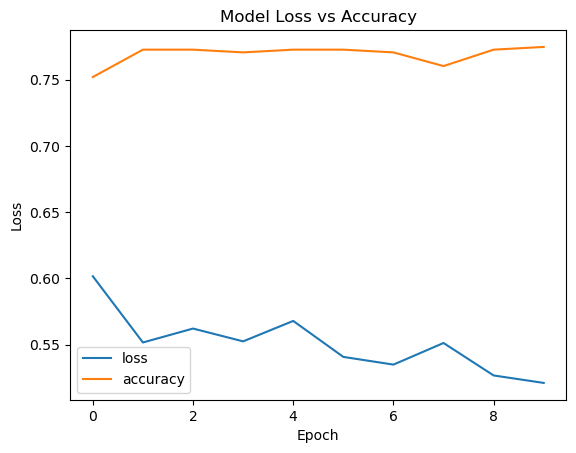

In [18]:
# plot the model loss and accuracy against the number of epochs

plt.plot(b_lstm_cnn_model_history2.history['loss'])
plt.plot(b_lstm_cnn_model_history2.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()

### Experiment O

`One embedding layer, spatial dropout layer, 3 Conv1D+MaxPooling1D layers, 3 bilstm layers`

In [20]:
b_lstm_cnn_model2 = Sequential()
b_lstm_cnn_model2.add(Embedding(vocab_size, 100, input_length=150, trainable=False))
b_lstm_cnn_model2.add(SpatialDropout1D(0.6))

b_lstm_cnn_model2.add(Conv1D(filters=150, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model2.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model2.add(Conv1D(filters=200, kernel_size=6, activation='relu'))
b_lstm_cnn_model2.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model2.add(Conv1D(filters=250, kernel_size=6, activation='relu'))
b_lstm_cnn_model2.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model2.add(Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model2.add(Dropout(0.4))

b_lstm_cnn_model2.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model2.add(Dropout(0.4))

b_lstm_cnn_model2.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
b_lstm_cnn_model2.add(Dropout(0.4))

b_lstm_cnn_model2.add(Flatten())
b_lstm_cnn_model2.add(Dense(64, activation='relu'))
b_lstm_cnn_model2.add(Dropout(0.5))
b_lstm_cnn_model2.add(Dense(1, activation='sigmoid'))

b_lstm_cnn_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_cnn_model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          1412400   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 150, 100)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_7 (Conv1D)           (None, 150, 150)          90150     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 75, 150)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 70, 200)           180200    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 35, 200)         

In [21]:
b_lstm_cnn_model2_history = b_lstm_cnn_model2.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=[x_test, y_test])

Epoch 1/15
16/16 [==============================] - 27s 631ms/step - loss: 0.5731 - acc: 0.7583 - val_loss: 0.7027 - val_acc: 0.7769
Epoch 2/15
16/16 [==============================] - 9s 599ms/step - loss: 0.5895 - acc: 0.7727 - val_loss: 0.5476 - val_acc: 0.7769
Epoch 3/15
16/16 [==============================] - 11s 703ms/step - loss: 0.5527 - acc: 0.7727 - val_loss: 0.5478 - val_acc: 0.7769
Epoch 4/15
16/16 [==============================] - 10s 659ms/step - loss: 0.5812 - acc: 0.7686 - val_loss: 0.5364 - val_acc: 0.7769
Epoch 5/15
16/16 [==============================] - 10s 610ms/step - loss: 0.5716 - acc: 0.7707 - val_loss: 0.5674 - val_acc: 0.7769
Epoch 6/15
16/16 [==============================] - 10s 615ms/step - loss: 0.5702 - acc: 0.7727 - val_loss: 0.5368 - val_acc: 0.7769
Epoch 7/15
16/16 [==============================] - 10s 643ms/step - loss: 0.5554 - acc: 0.7727 - val_loss: 0.5779 - val_acc: 0.7769
Epoch 8/15
16/16 [==============================] - 10s 658ms/step - l

In [22]:
filename = "b_lstm_cnn_model2.joblib"
joblib.dump(b_lstm_cnn_model2, filename)

['b_lstm_cnn_model2.joblib']

In [23]:
b_lstm_cnn_model2_evaluation = b_lstm_cnn_model2.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_cnn_model2_evaluation[0]}; Accuracy: {100*b_lstm_cnn_model2_evaluation[1]}%")

Loss: 0.5297068953514099; Accuracy: 77.68595218658447%


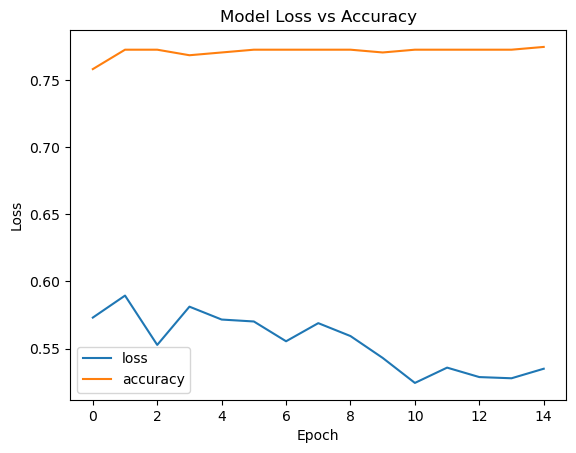

In [24]:
plt.plot(b_lstm_cnn_model2_history.history['loss'])
plt.plot(b_lstm_cnn_model2_history.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()

### Experiment P

`One embedding layer, spatial dropout layer, 4 Conv1D+MaxPooling1D layers, 4 bilstm layers`

In [25]:
b_lstm_cnn_model3 = Sequential()
b_lstm_cnn_model3.add(Embedding(vocab_size, 128, input_length=150))
b_lstm_cnn_model3.add(SpatialDropout1D(0.6))

b_lstm_cnn_model3.add(Conv1D(filters=100, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model3.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model3.add(Conv1D(filters=150, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model3.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model3.add(Conv1D(filters=200, kernel_size=6, activation='relu'))
b_lstm_cnn_model3.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model3.add(Conv1D(filters=250, kernel_size=6, activation='relu'))
b_lstm_cnn_model3.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model3.add(Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model3.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model3.add(Bidirectional(LSTM(250, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model3.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model3.add(Flatten())
b_lstm_cnn_model3.add(Dense(64, activation='relu'))
b_lstm_cnn_model3.add(Dropout(0.5))
b_lstm_cnn_model3.add(Dense(1, activation='sigmoid'))

b_lstm_cnn_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_cnn_model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 128)          1807872   
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 150, 128)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_10 (Conv1D)          (None, 150, 100)          76900     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 75, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 75, 150)           90150     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 37, 150)         

In [26]:
b_lstm_cnn_model3_history = b_lstm_cnn_model3.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=[x_test, y_test])

Epoch 1/15
16/16 [==============================] - 69s 920ms/step - loss: 0.5964 - acc: 0.7583 - val_loss: 0.5352 - val_acc: 0.7769
Epoch 2/15
16/16 [==============================] - 11s 694ms/step - loss: 0.5595 - acc: 0.7727 - val_loss: 0.5376 - val_acc: 0.7769
Epoch 3/15
16/16 [==============================] - 10s 634ms/step - loss: 0.5418 - acc: 0.7727 - val_loss: 0.5427 - val_acc: 0.7769
Epoch 4/15
16/16 [==============================] - 9s 566ms/step - loss: 0.4805 - acc: 0.7727 - val_loss: 0.4210 - val_acc: 0.7769
Epoch 5/15
16/16 [==============================] - 9s 546ms/step - loss: 0.1441 - acc: 0.9545 - val_loss: 0.5787 - val_acc: 0.8843
Epoch 6/15
16/16 [==============================] - 9s 578ms/step - loss: 0.1090 - acc: 0.9793 - val_loss: 0.3474 - val_acc: 0.9008
Epoch 7/15
16/16 [==============================] - 10s 603ms/step - loss: 0.1411 - acc: 0.9711 - val_loss: 1.1343 - val_acc: 0.8678
Epoch 8/15
16/16 [==============================] - 10s 614ms/step - los

In [27]:
filename = "b_lstm_cnn_model3.joblib"
joblib.dump(b_lstm_cnn_model3, filename)

['b_lstm_cnn_model3.joblib']

In [28]:
b_lstm_cnn_model3_evaluation = b_lstm_cnn_model3.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_cnn_model3_evaluation[0]}; Accuracy: {100*b_lstm_cnn_model3_evaluation[1]}%")

Loss: 1.314347505569458; Accuracy: 88.42975497245789%


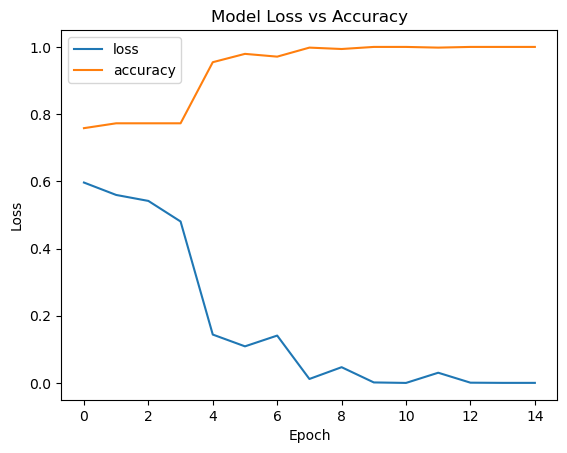

In [29]:
plt.plot(b_lstm_cnn_model3_history.history['loss'])
plt.plot(b_lstm_cnn_model3_history.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()

### Experiment P2

`One embedding layer, spatial dropout layer, 4 Conv1D+MaxPooling1D layers, 4 bilstm layers`

In [39]:
b_lstm_cnn_model4 = Sequential()
b_lstm_cnn_model4.add(Embedding(vocab_size, 128, input_length=150, trainable=False))
b_lstm_cnn_model4.add(SpatialDropout1D(0.6))

b_lstm_cnn_model4.add(Conv1D(filters=100, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model4.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model4.add(Conv1D(filters=150, kernel_size=6, padding='same', activation='relu'))
b_lstm_cnn_model4.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model4.add(Conv1D(filters=200, kernel_size=6, activation='relu'))
b_lstm_cnn_model4.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model4.add(Conv1D(filters=250, kernel_size=6, activation='relu'))
b_lstm_cnn_model4.add(MaxPooling1D(pool_size=2))

b_lstm_cnn_model4.add(Bidirectional(LSTM(150, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
# b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model4.add(Bidirectional(LSTM(200, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
# b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model4.add(Bidirectional(LSTM(250, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
# b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model4.add(Bidirectional(LSTM(300, dropout=0.5, recurrent_dropout=0.5)))
# b_lstm_cnn_model3.add(Dropout(0.4))

b_lstm_cnn_model4.add(Flatten())
b_lstm_cnn_model4.add(Dense(64, activation='relu'))
b_lstm_cnn_model4.add(Dropout(0.5))
b_lstm_cnn_model4.add(Dense(1, activation='sigmoid'))

b_lstm_cnn_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
b_lstm_cnn_model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 128)          1807872   
                                                                 
 spatial_dropout1d_11 (Spati  (None, 150, 128)         0         
 alDropout1D)                                                    
                                                                 
 conv1d_18 (Conv1D)          (None, 150, 100)          76900     
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 75, 100)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 75, 150)           90150     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 37, 150)        

In [42]:
b_lstm_cnn_model4_history = b_lstm_cnn_model4.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=[x_test, y_test])

Epoch 1/30
16/16 [==============================] - 5s 307ms/step - loss: 0.5503 - acc: 0.7727 - val_loss: 0.5365 - val_acc: 0.7769
Epoch 2/30
16/16 [==============================] - 5s 300ms/step - loss: 0.5477 - acc: 0.7727 - val_loss: 0.5353 - val_acc: 0.7769
Epoch 3/30
16/16 [==============================] - 5s 295ms/step - loss: 0.5394 - acc: 0.7727 - val_loss: 0.5393 - val_acc: 0.7686
Epoch 4/30
16/16 [==============================] - 5s 304ms/step - loss: 0.5267 - acc: 0.7769 - val_loss: 0.5337 - val_acc: 0.7769
Epoch 5/30
16/16 [==============================] - 5s 331ms/step - loss: 0.5673 - acc: 0.7727 - val_loss: 0.5362 - val_acc: 0.7769
Epoch 6/30
16/16 [==============================] - 6s 354ms/step - loss: 0.5458 - acc: 0.7727 - val_loss: 0.5313 - val_acc: 0.7769
Epoch 7/30
16/16 [==============================] - 6s 367ms/step - loss: 0.5459 - acc: 0.7727 - val_loss: 0.5326 - val_acc: 0.7769
Epoch 8/30
16/16 [==============================] - 6s 403ms/step - loss: 0.

In [43]:
b_lstm_cnn_model4_evaluation = b_lstm_cnn_model4.evaluate(x_test, y_test, verbose=False)

print(f"Loss: {b_lstm_cnn_model4_evaluation[0]}; Accuracy: {100*b_lstm_cnn_model4_evaluation[1]}%")

Loss: 0.5309200882911682; Accuracy: 77.68595218658447%


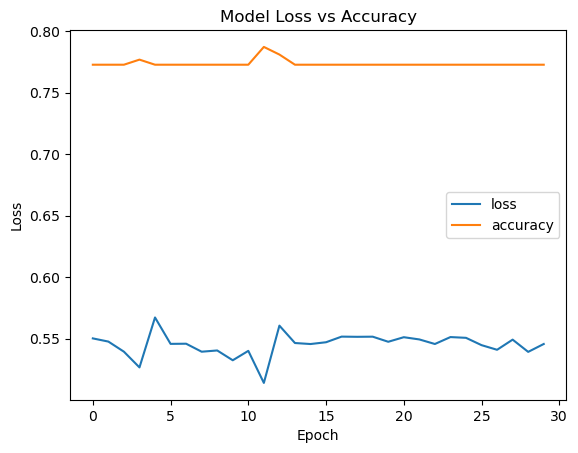

In [44]:
plt.plot(b_lstm_cnn_model4_history.history['loss'])
plt.plot(b_lstm_cnn_model4_history.history['acc'])
plt.title('Model Loss vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'accuracy'])
plt.show()